In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as tree
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

seed = 42

In [2]:
data_raw_full = pd.read_excel('nshap_w1_w2_w3_core_disposition.xls')
data_raw_full.drop(columns=["A2. Diabetic Glycosylated Hemoglobin",
                            "B5. Systolic Blood Pressure",
                            "B6. Diastolic Blood Pressure",
                            "B7. Rapid Pulse",
                            "G20. Central Obesity",
                            "G21. Obese",
                            "H22. Atypical Sleep",
                            "H23. Wakes Up Tired",
                            "I25. Heavy Drinker",
                            "I26. Smoker",
                            "J28. Perceived Stress",
                            "J30. Loneliness",
                            "J32. Low Self-Esteem",
                            "J33. Unhappiness",
                            "K34. Cognition",
                            "L35. Taste Identification",
                            "L36. Visual Acuity (Tested)",
                            "L37. Night Vision",
                            "L38. Sense of Touch Threshold",
                            "L39. Odor Identification",
                            "L40. Interviewer-Rated Hearing",
                            "M42. Chronic Inflammation",
                            "N47. Bone Fracture since Age 45",
                            "N48. Osteoporotic Fracture",
                            "N50. Difficulty with Activities of Daily Living",
                            "S68. Perceived Isolation"
                            ],
                   inplace=True)


In [3]:
data_raw_full

respondent id  W3 sample type  W3 Recode of Final Disposition  \
0          10000050             1.0                             1.0   
1          10000060             1.0                             2.0   
2          10000070             1.0                             2.0   
3          10000080             1.0                             1.0   
4          10000090             1.0                             1.0   
...             ...             ...                             ...   
3000       10043500             NaN                             NaN   
3001       10043600             NaN                             NaN   
3002       10043690             NaN                             NaN   
3003       10043810             NaN                             NaN   
3004       10043930             NaN                             NaN   

      W3 Deceased  W2 Recode of Final Disposition  W2 Deceased  \
0             0.0                               1          0.0   
1             1.0                               1          0.0   
2             1.0                               1          0.0   
3             0.0                               5          0.0   
4             0.0                               1          0.0   
...           ...                             ...          ...   
3000          NaN                               2          1.0   
3001          NaN                               2          1.0   
3002          NaN                               2          1.0   
3003          NaN                               2          1.0   
3004          NaN                               2          1.0   

      person-level weight (nonresponse adjusted)  (pseudo) sampling stratum  \
0                                       1.151978                         56   
1                                       0.649874                         56   
2                                       0.639700                         21   
3                                       1.193744                         15   
4                                       0.299111                         31   
...                                          ...                        ...   
3000                                    0.649874                         50   
3001                                    0.401704                         42   
3002                                    0.674039                          2   
3003                                    0.689935                          2   
3004                                    0.987789                         47   

      (pseudo) psu  Final Social Comprehensive Classes  ...  \
0              562                                   1  ...   
1              562                                   5  ...   
2              211                                   1  ...   
3              152                                   4  ...   
4              311                                   4  ...   
...            ...                                 ...  ...   
3000           502                                   4  ...   
3001           422                                   5  ...   
3002            22                                   6  ...   
3003            21                                   2  ...   
3004           471                                   3  ...   

      R66. High Social Strain  S67. Lack of Network Diversity  \
0                         0.0                               1   
1                         0.0                               0   
2                         0.0                               0   
3                         0.0                               1   
4                         1.0                               0   
...                       ...                             ...   
3000                      NaN                               1   
3001                      0.0                               1   
3002                      0.0                               1   
3003

In [4]:
# W2 > 3, 但W3可以确定，应该保留
data_raw_full.drop(index=data_raw_full[data_raw_full['W3 Recode of Final Disposition'] > 3].index, inplace=True)
data_raw_full.drop(index=data_raw_full[data_raw_full['W2 Recode of Final Disposition'] > 3].index, inplace=True)

data_raw_full['Label'] = (data_raw_full['W3 Recode of Final Disposition'] > 1) | (
            data_raw_full['W2 Recode of Final Disposition'] > 1)
data_raw_full['Label'] = data_raw_full['Label'].apply(int)
data_raw_full['Label'].sum()

1120

In [5]:
len(data_raw_full)

2682

In [6]:
(data_raw_full['W3 Recode of Final Disposition'] == 1).sum()

1554

In [7]:
# Multiple-Impute 优化一下
# Algorithm deal with missing
imp = SimpleImputer(strategy='most_frequent')
data_filled = imp.fit_transform(data_raw_full)
data_filled = pd.DataFrame(data_filled, columns=data_raw_full.columns)
data_filled

respondent id  W3 sample type  W3 Recode of Final Disposition  \
0        10000050.0             1.0                             1.0   
1        10000060.0             1.0                             2.0   
2        10000070.0             1.0                             2.0   
3        10000090.0             1.0                             1.0   
4        10000100.0             1.0                             1.0   
...             ...             ...                             ...   
2677     10043500.0             1.0                             1.0   
2678     10043600.0             1.0                             1.0   
2679     10043690.0             1.0                             1.0   
2680     10043810.0             1.0                             1.0   
2681     10043930.0             1.0                             1.0   

      W3 Deceased  W2 Recode of Final Disposition  W2 Deceased  \
0             0.0                             1.0          0.0   
1             1.0                             1.0          0.0   
2             1.0                             1.0          0.0   
3             0.0                             1.0          0.0   
4             0.0                             1.0          0.0   
...           ...                             ...          ...   
2677          0.0                             2.0          1.0   
2678          0.0                             2.0          1.0   
2679          0.0                             2.0          1.0   
2680          0.0                             2.0          1.0   
2681          0.0                             2.0          1.0   

      person-level weight (nonresponse adjusted)  (pseudo) sampling stratum  \
0                                       1.151978                       56.0   
1                                       0.649874                       56.0   
2                                       0.639700                       21.0   
3                                       0.299111                       31.0   
4                                       0.347846                       36.0   
...                                          ...                        ...   
2677                                    0.649874                       50.0   
2678                                    0.401704                       42.0   
2679                                    0.674039                        2.0   
2680                                    0.689935                        2.0   
2681                                    0.987789                       47.0   

      (pseudo) psu  Final Social Comprehensive Classes  ...  \
0            562.0                                 1.0  ...   
1            562.0                                 5.0  ...   
2            211.0                                 1.0  ...   
3            311.0                                 4.0  ...   
4            361.0                                 2.0  ...   
...            ...                                 ...  ...   
2677         502.0                                 4.0  ...   
2678         422.0                                 5.0  ...   
2679          22.0                                 6.0  ...   
2680          21.0                                 2.0  ...   
2681         471.0                                 3.0  ...   

      S67. Lack of Network Diversity  S69. Low Social Participation  \
0                                1.0                            0.0   
1                                0.0                            0.0   
2                                0.0                            0.0   
3                                0.0                            0.0   
4                                1.0                            0.0   
...                              ...                            ...   
2677                             1.0                            0.0   
2678                             1.0                            1.0   
2679           

In [8]:
data_filled["Weight"] = data_filled["person-level weight (nonresponse adjusted)"]
#data_filled["Weight_adj"] = data_filled["person-level weight (nonresponse adjusted)"] * data_filled[
#    "(pseudo) sampling stratum"]

data_filled.drop(columns=["respondent id",
                          "W3 sample type",
                          "W3 Recode of Final Disposition",
                          "W3 Deceased",
                          "W2 Recode of Final Disposition",
                          "W2 Deceased",
                          "person-level weight (nonresponse adjusted)",
                          "(pseudo) sampling stratum",
                          "(pseudo) psu",
                          "Final Social Comprehensive Classes",
                          "Comprehensive Health Classes",
                          "Medical Model Classes",
                          "self-rated mental health",
                          "self-rated physical health"
                          ], inplace=True)

In [9]:
data_filled
# 1 interviewed
# 2 deceased
# 3 too sick to interview
# 4 5 6 delete

# person-level, sampling weight (nshap over sample black, hispanic, blabla)
# sampling stratum
# primary sampling unit (psu, person-level)

A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
0              0.0          1.0                                      0.0   
1              0.0          0.0                                      0.0   
2              0.0          0.0                                      0.0   
3              0.0          0.0                                      0.0   
4              0.0          0.0                                      0.0   
...            ...          ...                                      ...   
2677           0.0          0.0                                      0.0   
2678           1.0          0.0                                      0.0   
2679           0.0          0.0                                      0.0   
2680           0.0          1.0                                      0.0   
2681           0.0          1.0                                      0.0   

      B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
0                  0.0               0.0                          0.0   
1                  1.0               0.0                          0.0   
2                  0.0               0.0                          0.0   
3                  0.0               0.0                          0.0   
4                  1.0               0.0                          0.0   
...                ...               ...                          ...   
2677               0.0               0.0                          1.0   
2678               1.0               0.0                          0.0   
2679               0.0               0.0                          0.0   
2680               1.0               0.0                          0.0   
2681               1.0               0.0                          0.0   

      B10. Heart Failure  BT_T2. Systolic Blood Pressure  \
0                    0.0                             1.0   
1                    0.0                             1.0   
2                    0.0                             1.0   
3                    1.0                             0.0   
4                    0.0                             0.0   
...                  ...                             ...   
2677                 0.0                             1.0   
2678                 0.0                             1.0   
2679                 0.0                             0.0   
2680                 0.0                             0.0   
2681                 0.0                             0.0   

      B6_T2. Diastolic Blood Pressure  B7_T1. Rapid Pulse  ...  \
0                                 1.0                 1.0  ...   
1                                 0.0                 0.0  ...   
2                                 0.0                 1.0  ...   
3                                 0.0                 1.0  ...   
4                                 0.0                 1.0  ...   
...                               ...                 ...  ...   
2677                              0.0                 0.0  ...   
2678                              0.0                 0.0  ...   
2679                              0.0                 0.0  ...   
2680                              0.0                 0.0  ...   
2681                              1.0                 0.0  ...   

      R66. High Social Strain  S67. Lack of Network Diversity  \
0                         0.0                             1.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         1.0                             0.0   
4                         0.0                             1.0   
...                       ...                             ...   
2677                      0.0                             1.0   
2678                      0.0                             1.0   
2679                      0.0                             1.0   
2680                      0.0                       

## Decision Tree

In [10]:
data_nona = data_filled.copy()
seed = 42
data_nona.drop(columns=[
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_nona=data_nona[[
    "P55. Frequency of Sexual Ideation",
    "P56. Frequency of Sex",
    "J30_T2. Loneliness",
    "R63. Unmarried/Unpartnered",
    "R64. Limited Network Size",
    "R65. Low Social Support",
    "R66. High Social Strain",
    "S67. Lack of Network Diversity",
    "S69. Low Social Participation",
    "Label",
    "Weight"]
]

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)


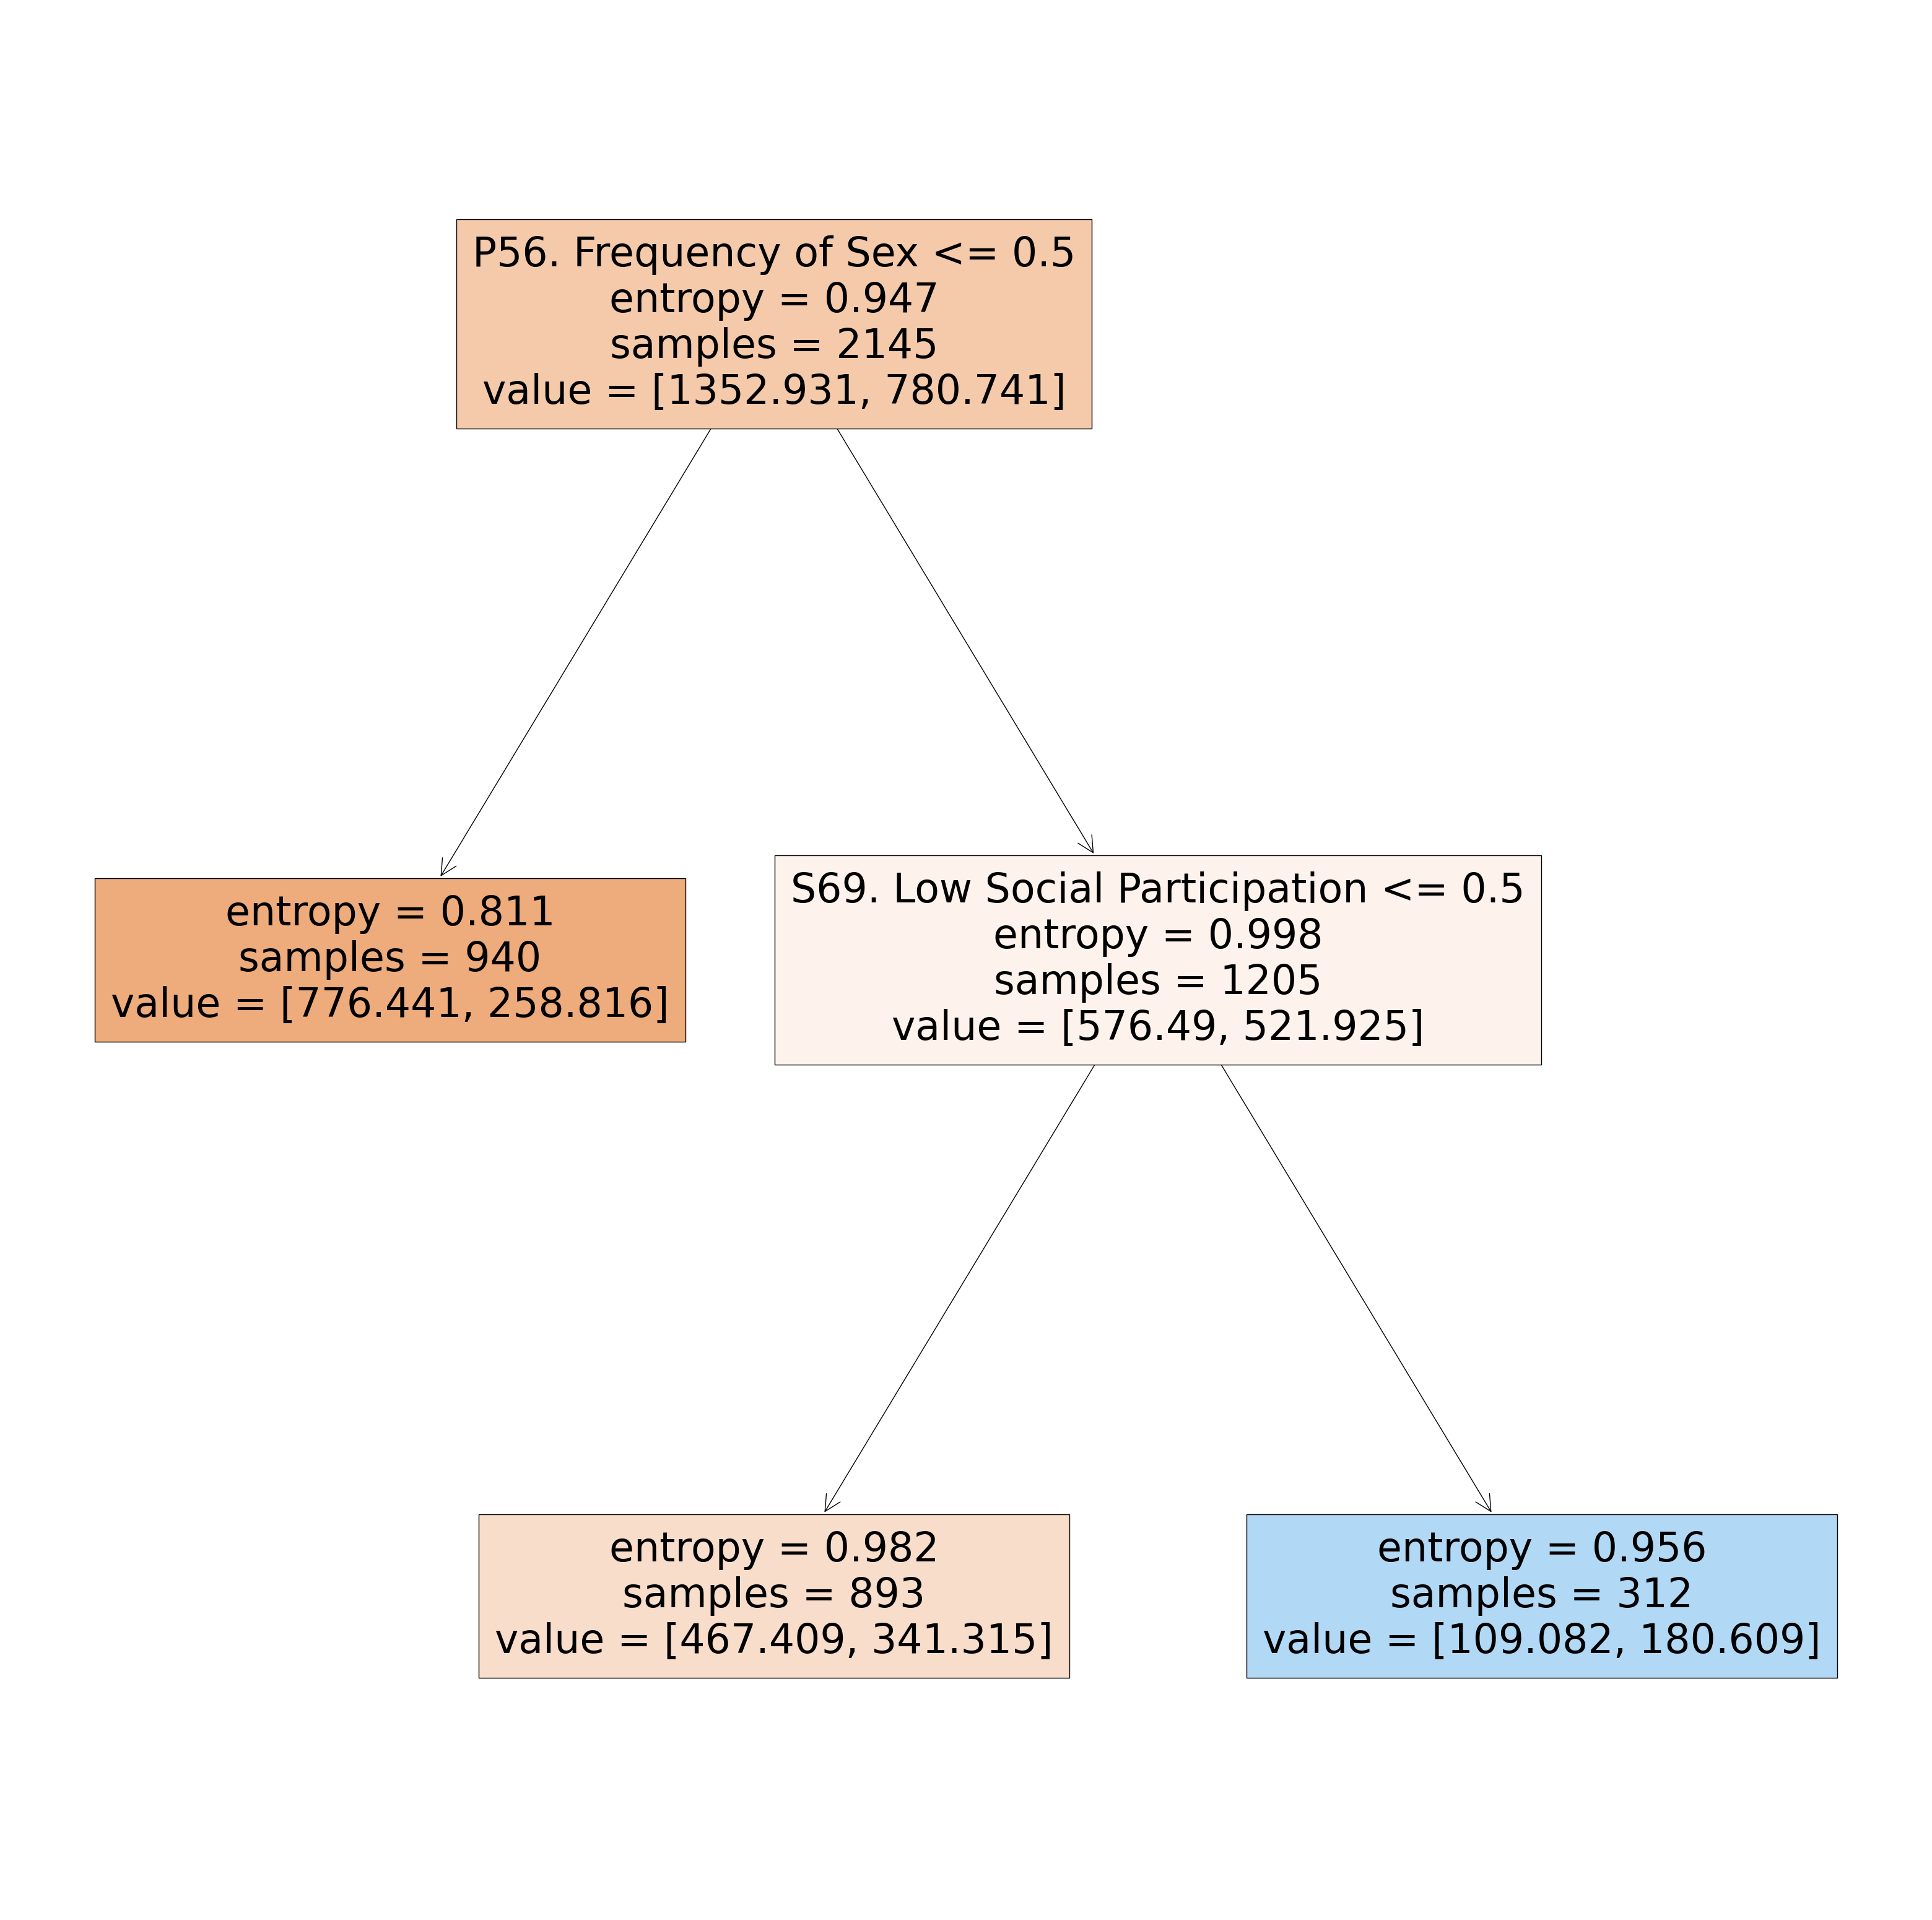

Performence on train set 0.6676091044066561
Performence on test set 0.6305440089029637
              precision    recall  f1-score   support

         0.0       0.63      0.93      0.75 334.7975964695215
         1.0       0.60      0.16      0.26 213.9978836029768

    accuracy                           0.63 548.7954800724983
   macro avg       0.62      0.55      0.51 548.7954800724983
weighted avg       0.62      0.63      0.56 548.7954800724983



'print("Performence on train set",\n      metrics.accuracy_score(DT_clf.predict(X_train), y_train))\ny_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])\n\nprint("Performence on test set", metrics.accuracy_score(y_pred, y_test))\n\nprint(metrics.classification_report(y_test, y_pred))'

In [11]:
# 4到5层的树
# 把3放进去试试

#The re-weighted sample basing on statistics can better reflect the universal distribution, so we rised the min-impurity-decrease to 0.01. And do the same logic to train and evaluate.
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

'''print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])

print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))'''

control age race(ethnicity) gender education
age->age group
casual tree
特征不重复

variable重新整理一下，weight&self-rated** ；
三张图：all，gender difference，social feature ；

## Gender Difference

2145


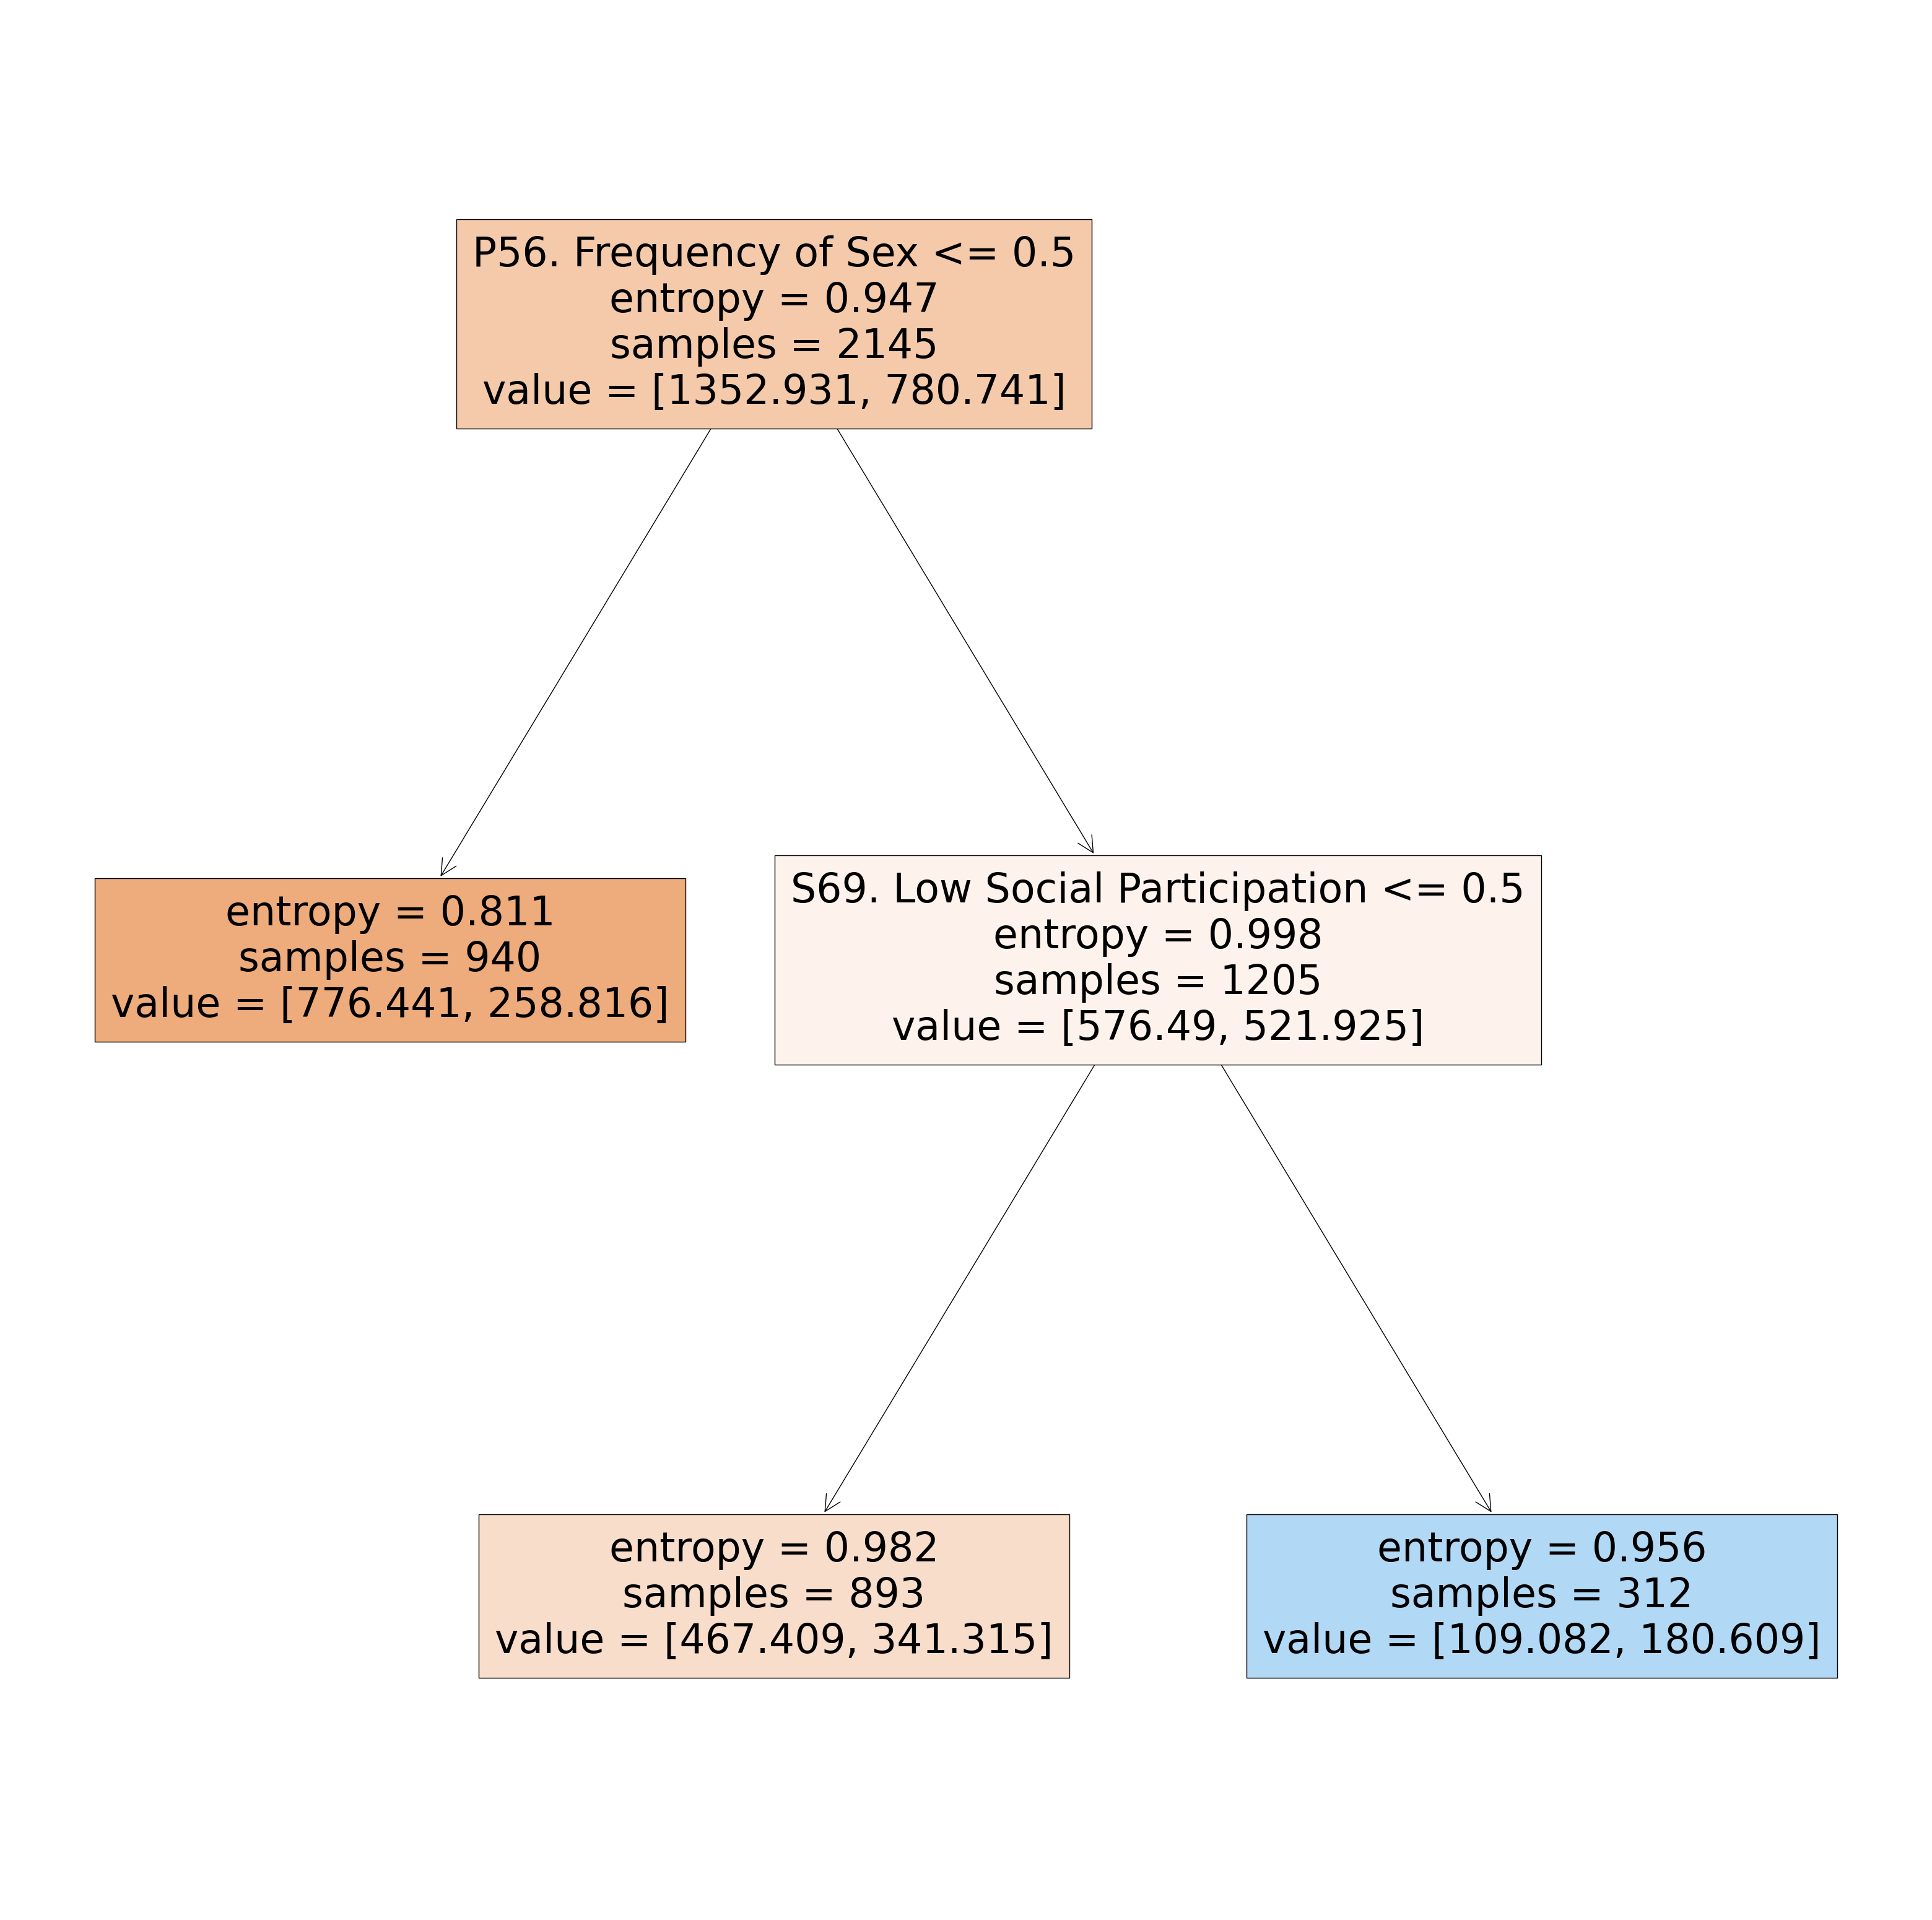

Performence on train set 0.6676091044066561
Performence on test set 0.6305440089029637
              precision    recall  f1-score   support

         0.0       0.63      0.93      0.75 334.7975964695215
         1.0       0.60      0.16      0.26 213.9978836029768

    accuracy                           0.63 548.7954800724983
   macro avg       0.62      0.55      0.51 548.7954800724983
weighted avg       0.62      0.63      0.56 548.7954800724983



In [12]:
data_nona = data_filled.copy()
seed = 42
data_nona.drop(columns=[
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_nona=data_nona[[
    "P55. Frequency of Sexual Ideation",
    "P56. Frequency of Sex",
    "J30_T2. Loneliness",
    "R63. Unmarried/Unpartnered",
    "R64. Limited Network Size",
    "R65. Low Social Support",
    "R66. High Social Strain",
    "S67. Lack of Network Diversity",
    "S69. Low Social Participation",
    "Label",
    "Weight"]
]

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [16]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  P55. Frequency of Sexual Ideation  P56. Frequency of Sex  \
0      1.0                                1.0                    1.0   
2      1.0                                1.0                    0.0   
5      1.0                                0.0                    1.0   
7      1.0                                0.0                    1.0   
10     0.0                                0.0                    1.0   
..     ...                                ...                    ...   
524    1.0                                0.0                    1.0   
525    1.0                                1.0                    1.0   
526    1.0                                0.0                    1.0   
532    1.0                                0.0                    1.0   
536    1.0                                1.0                    1.0   

     J30_T2. Loneliness  R63. Unmarried/Unpartnered  \
0                   0.0                         0.0   
2                   0.0                         0.0   
5                   1.0                         1.0   
7                   0.0                         1.0   
10                  1.0                         1.0   
..                  ...                         ...   
524                 0.0                         1.0   
525                 1.0                         1.0   
526                 0.0                         0.0   
532                 0.0                         1.0   
536                 0.0                         0.0   

     R64. Limited Network Size  R65. Low Social Support  \
0                          0.0                      0.0   
2                          0.0                      0.0   
5                          0.0                      0.0   
7                          0.0                      1.0   
10                         0.0                      0.0   
..                         ...                      ...   
524                        0.0                      1.0   
525                        0.0                      0.0   
526                        0.0                      0.0   
532                        0.0                      0.0   
536                        0.0                      0.0   

     R66. High Social Strain  S67. Lack of Network Diversity  \
0                        0.0                             0.0   
2                        0.0                             0.0   
5                        0.0                             1.0   
7                        0.0                             0.0   
10                       0.0                             0.0   
..                       ...                             ...   
524                      0.0                             0.0   
525                      0.0                             1.0   
526                      0.0                             0.0   
532                      0.0                             0.0   
536                      0.0                             0.0   

     S69. Low Social Participation  
0                              0.0  
2                              0.0  
5                              0.0  
7                              0.0  
10                             1.0  
..                             ...  
524                            0.0  
525                            0.0  
526                            0.0  
532                            0.0  
536                            0.0  

[207 rows x 10 columns]

2145


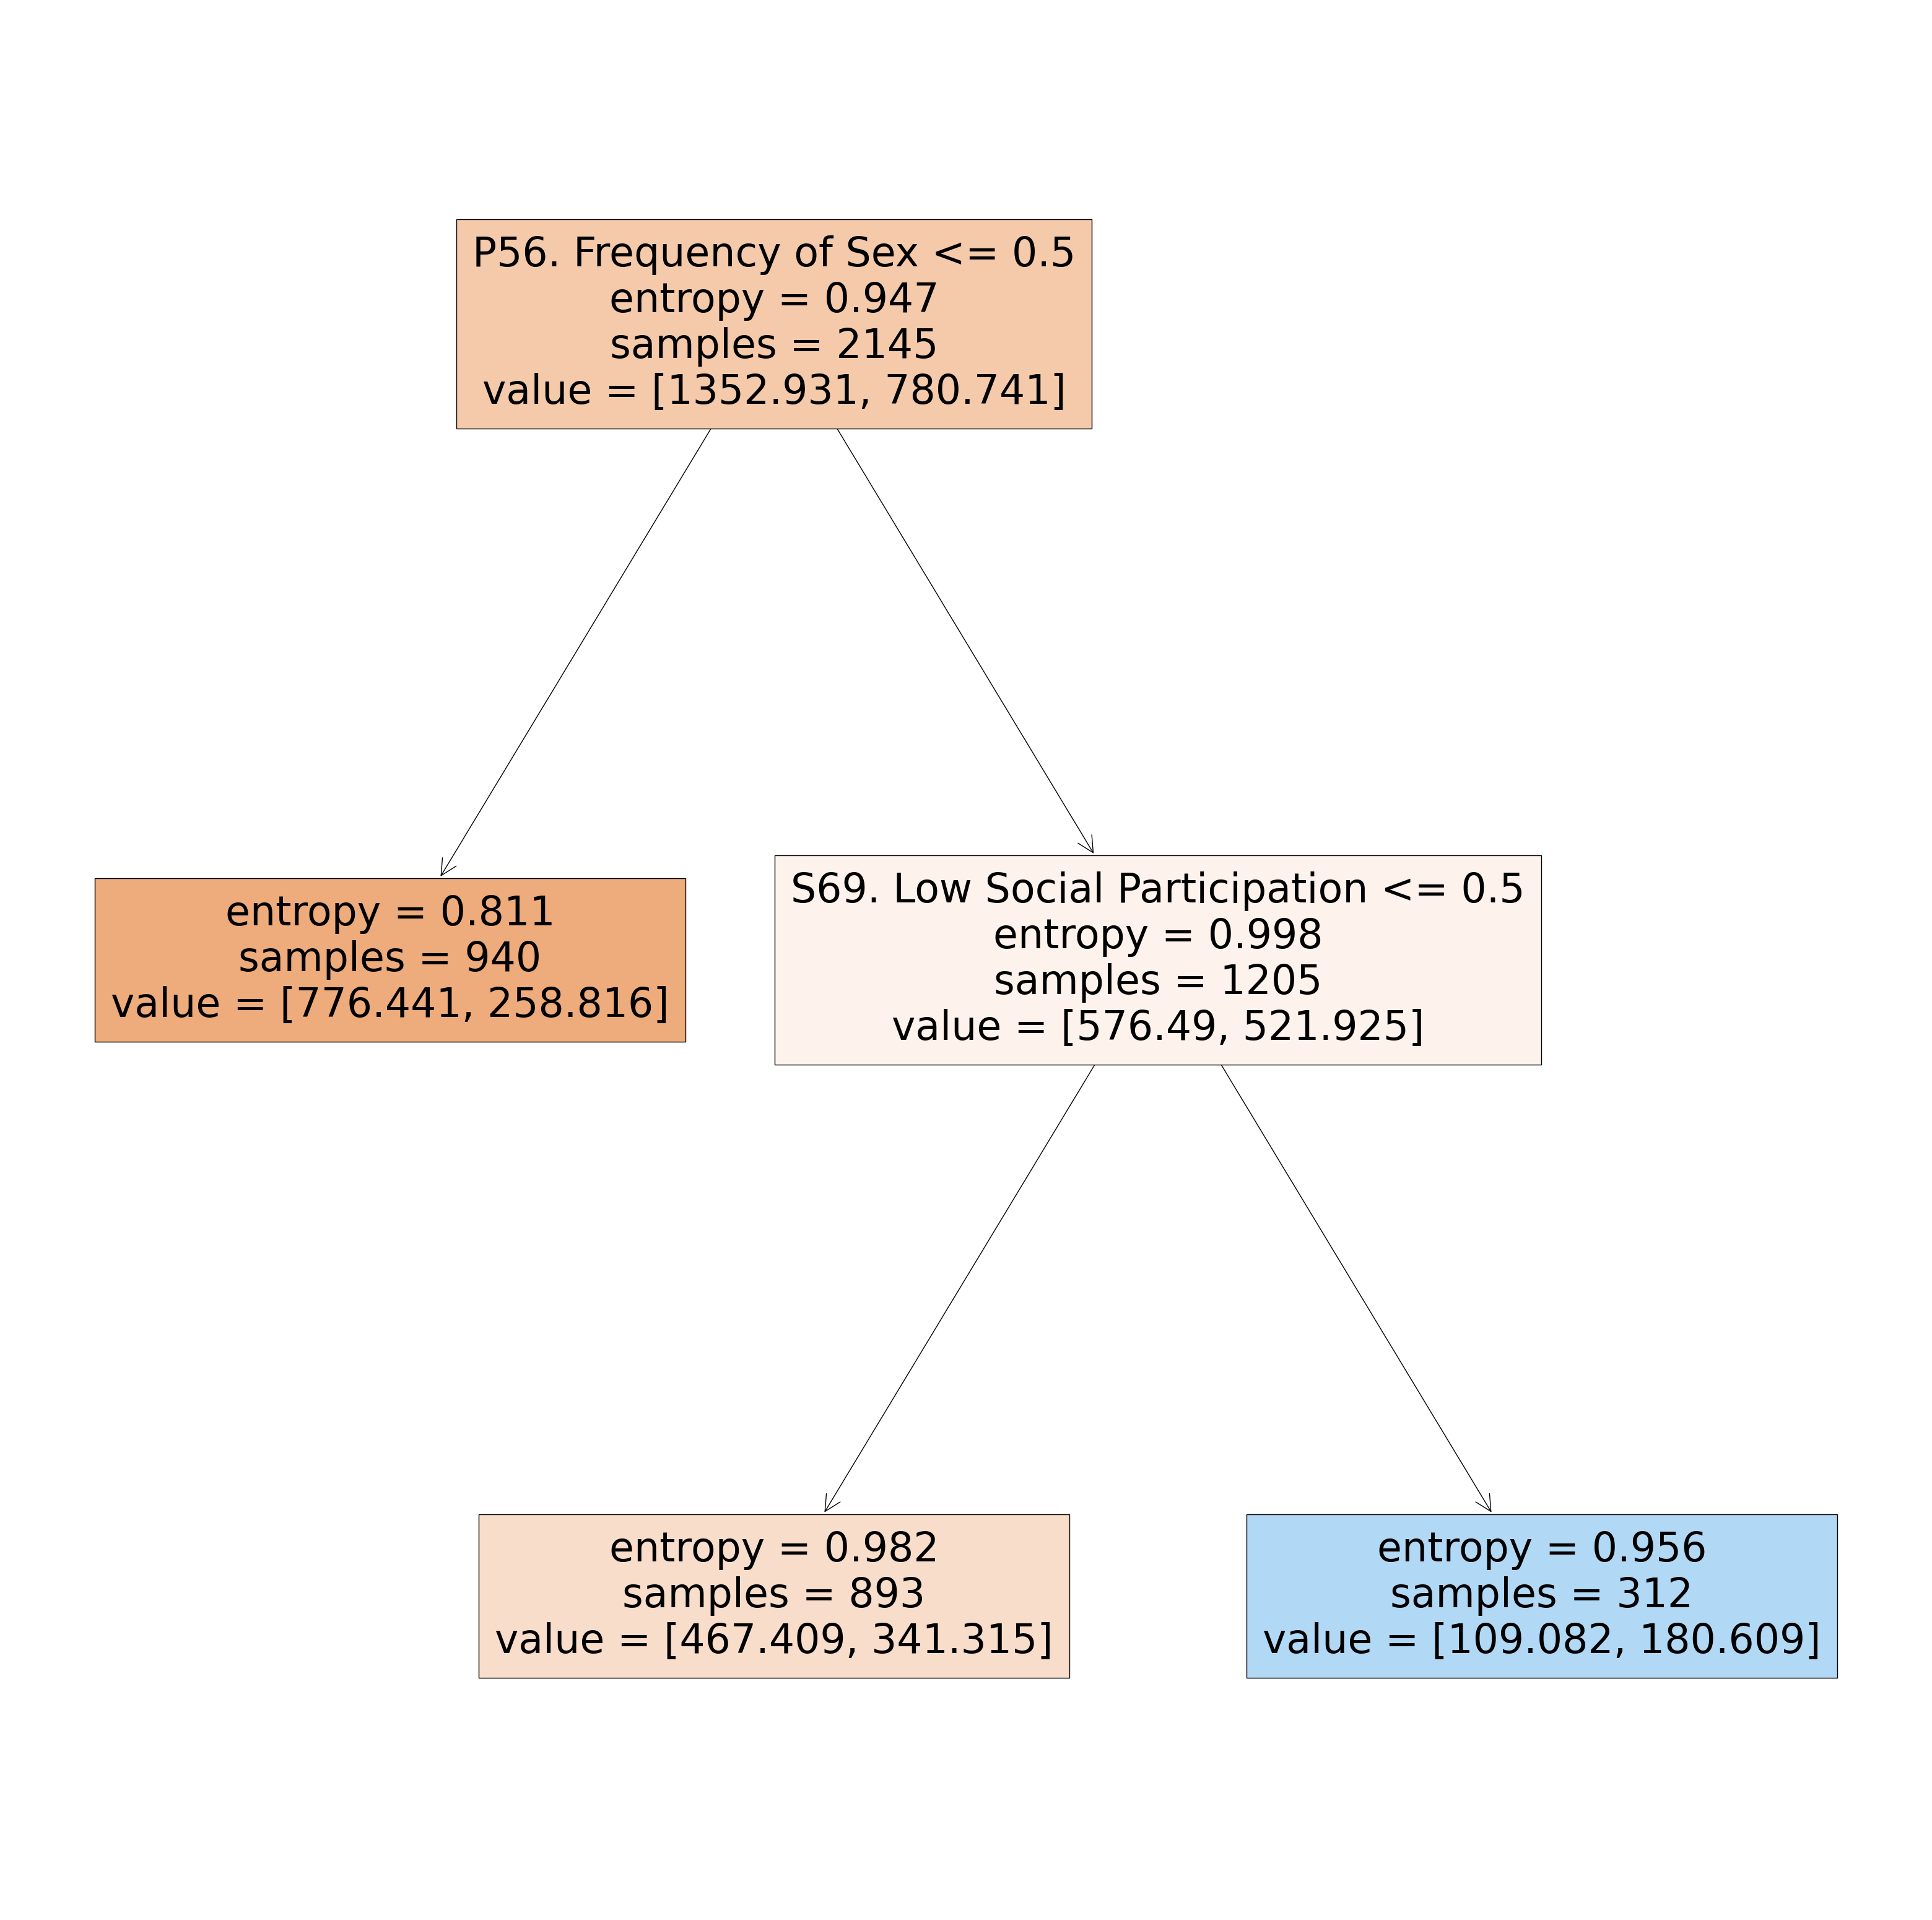

Performence on train set 0.6676091044066561
Performence on test set 0.6305440089029637
              precision    recall  f1-score   support

         0.0       0.63      0.93      0.75 334.7975964695215
         1.0       0.60      0.16      0.26 213.9978836029768

    accuracy                           0.63 548.7954800724983
   macro avg       0.62      0.55      0.51 548.7954800724983
weighted avg       0.62      0.63      0.56 548.7954800724983



In [13]:
data_nona = data_filled.copy()
seed = 42
data_nona.drop(columns=[
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_nona=data_nona[[
    "P55. Frequency of Sexual Ideation",
    "P56. Frequency of Sex",
    "J30_T2. Loneliness",
    "R63. Unmarried/Unpartnered",
    "R64. Limited Network Size",
    "R65. Low Social Support",
    "R66. High Social Strain",
    "S67. Lack of Network Diversity",
    "S69. Low Social Participation",
    "Label",
    "Weight"]
]

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [15]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  P55. Frequency of Sexual Ideation  P56. Frequency of Sex  \
0      1.0                                1.0                    1.0   
2      1.0                                1.0                    0.0   
5      1.0                                0.0                    1.0   
7      1.0                                0.0                    1.0   
10     0.0                                0.0                    1.0   
..     ...                                ...                    ...   
524    1.0                                0.0                    1.0   
525    1.0                                1.0                    1.0   
526    1.0                                0.0                    1.0   
532    1.0                                0.0                    1.0   
536    1.0                                1.0                    1.0   

     J30_T2. Loneliness  R63. Unmarried/Unpartnered  \
0                   0.0                         0.0   
2                   0.0                         0.0   
5                   1.0                         1.0   
7                   0.0                         1.0   
10                  1.0                         1.0   
..                  ...                         ...   
524                 0.0                         1.0   
525                 1.0                         1.0   
526                 0.0                         0.0   
532                 0.0                         1.0   
536                 0.0                         0.0   

     R64. Limited Network Size  R65. Low Social Support  \
0                          0.0                      0.0   
2                          0.0                      0.0   
5                          0.0                      0.0   
7                          0.0                      1.0   
10                         0.0                      0.0   
..                         ...                      ...   
524                        0.0                      1.0   
525                        0.0                      0.0   
526                        0.0                      0.0   
532                        0.0                      0.0   
536                        0.0                      0.0   

     R66. High Social Strain  S67. Lack of Network Diversity  \
0                        0.0                             0.0   
2                        0.0                             0.0   
5                        0.0                             1.0   
7                        0.0                             0.0   
10                       0.0                             0.0   
..                       ...                             ...   
524                      0.0                             0.0   
525                      0.0                             1.0   
526                      0.0                             0.0   
532                      0.0                             0.0   
536                      0.0                             0.0   

     S69. Low Social Participation  
0                              0.0  
2                              0.0  
5                              0.0  
7                              0.0  
10                             1.0  
..                             ...  
524                            0.0  
525                            0.0  
526                            0.0  
532                            0.0  
536                            0.0  

[207 rows x 10 columns]

## Age

704


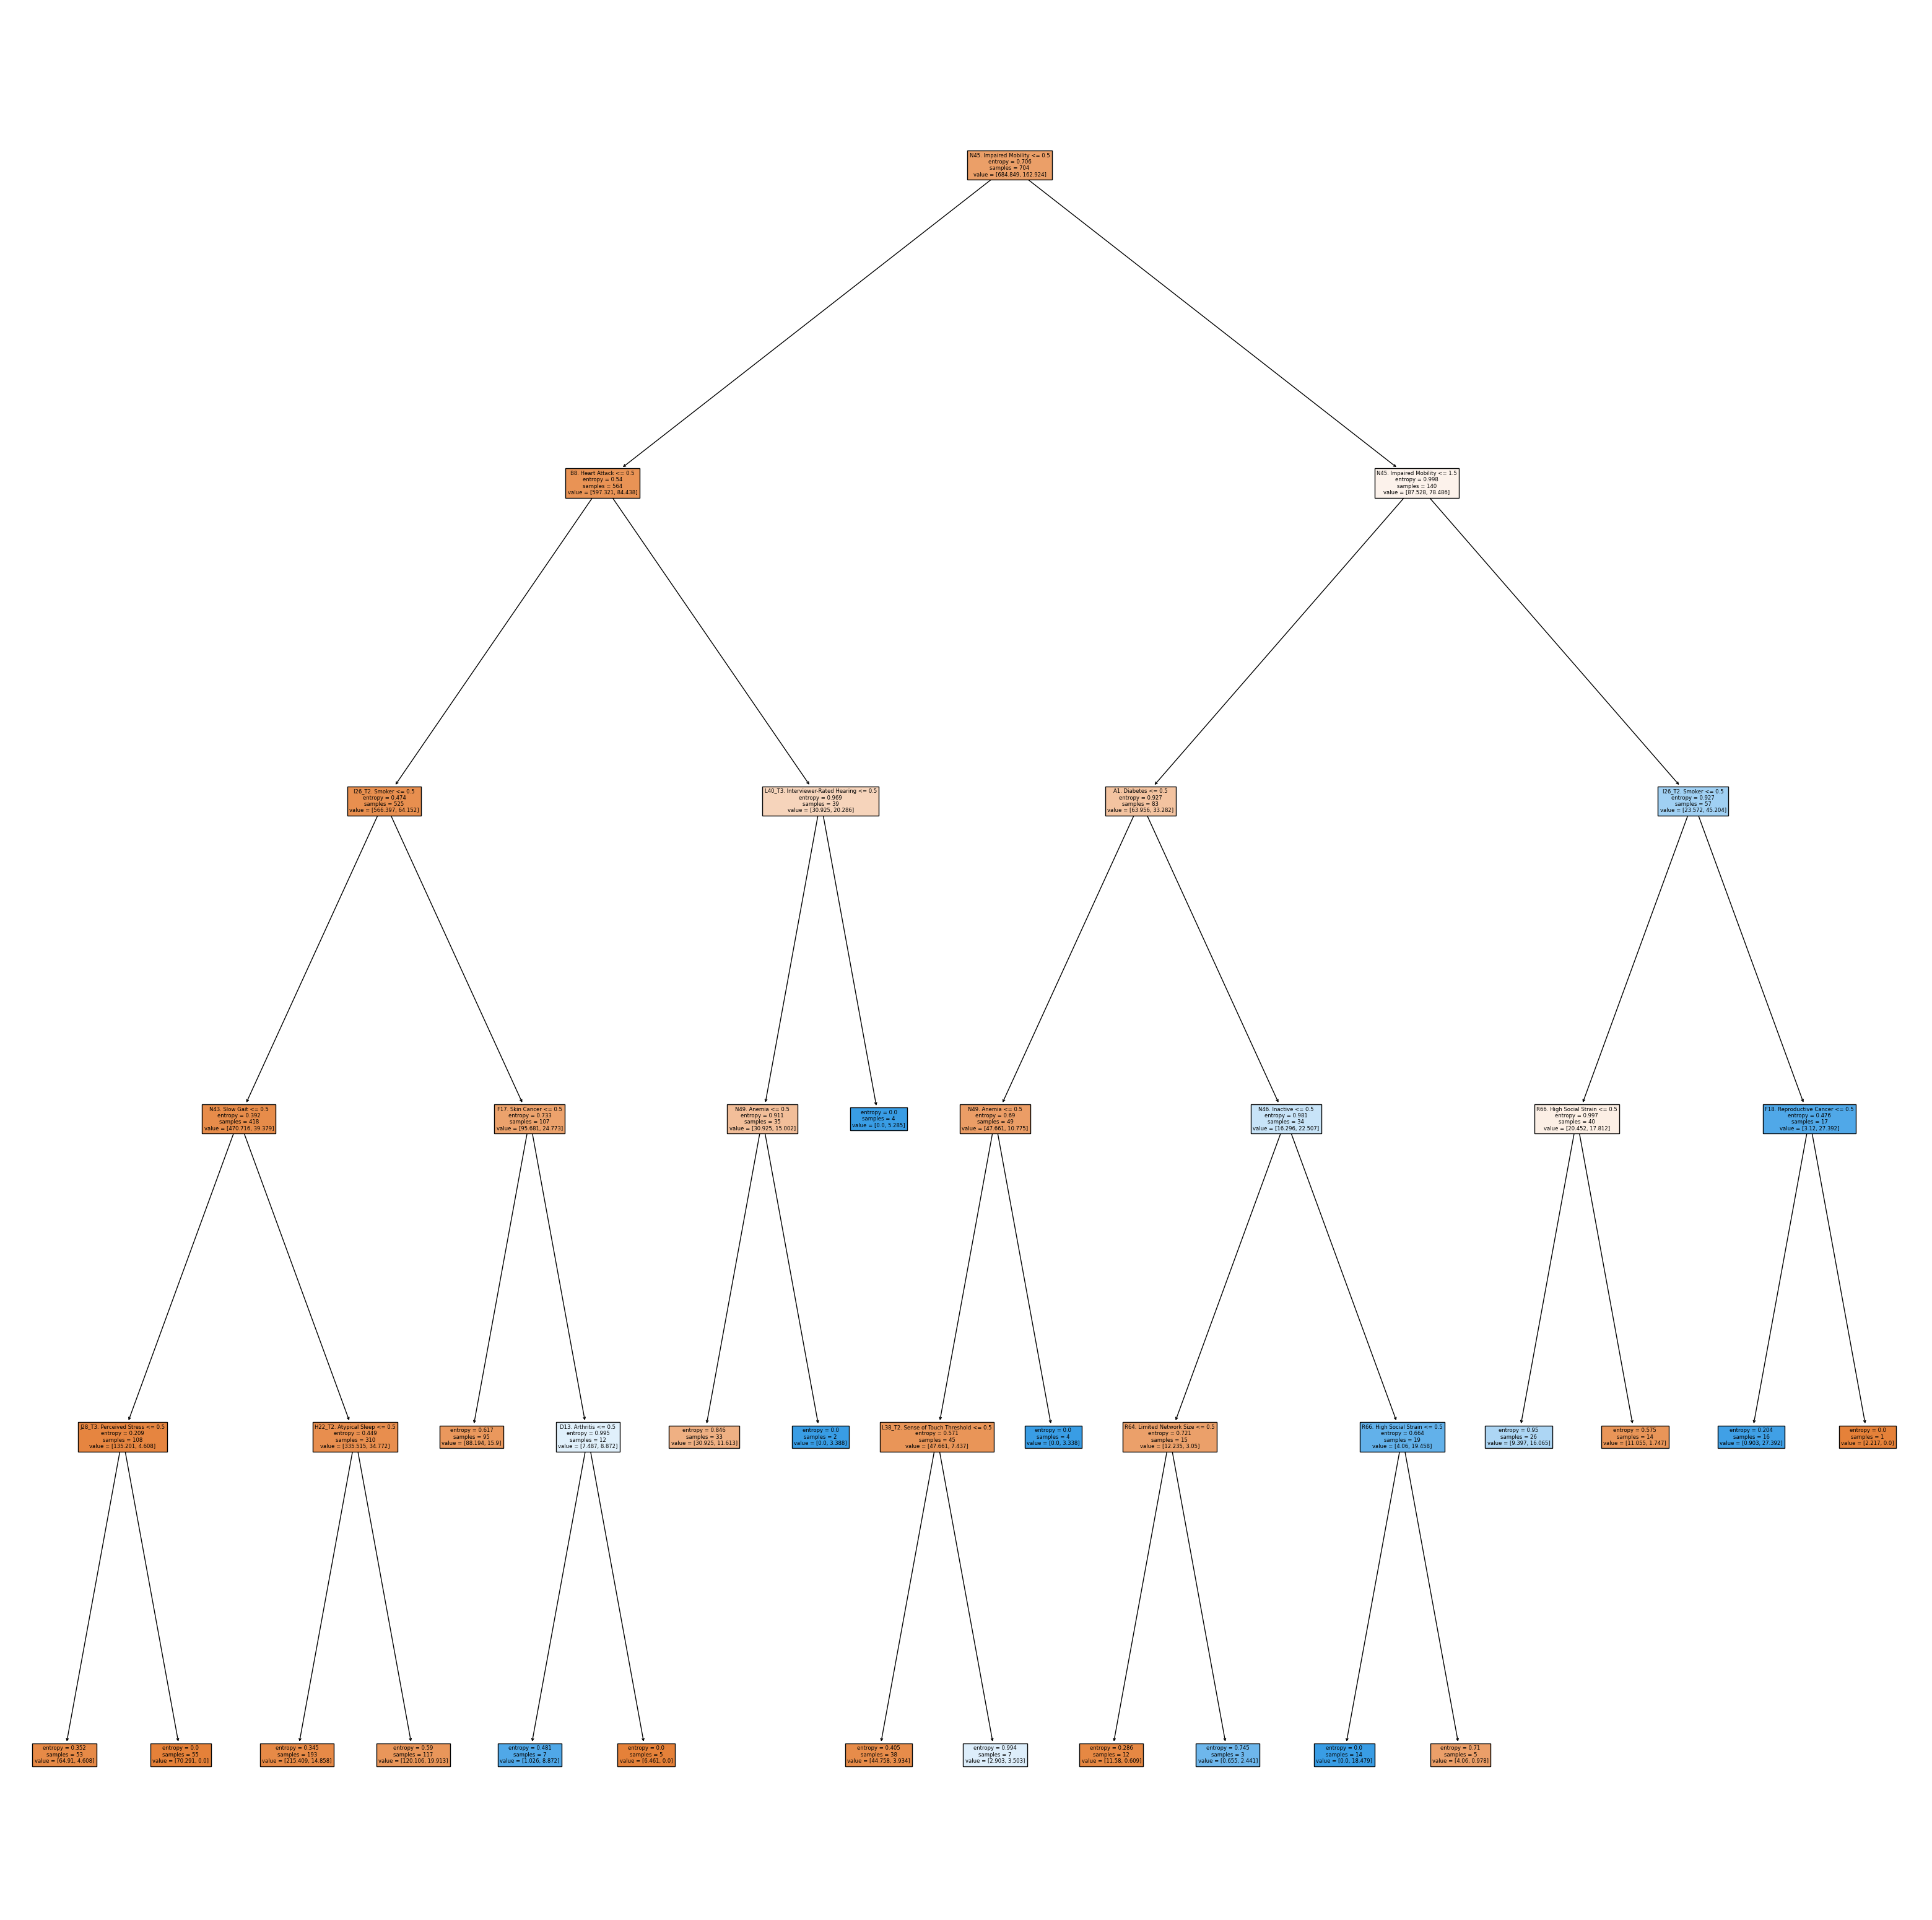

Performence on train set 0.8949666802947838
Performence on test set 0.8012158861367368
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88 190.75913679599762
         1.0       0.44      0.25      0.32 43.54120671749115

    accuracy                           0.80 234.30034351348877
   macro avg       0.64      0.59      0.60 234.30034351348877
weighted avg       0.77      0.80      0.78 234.30034351348877



In [74]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [76]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
6      0.0           0.0          1.0   
7      1.0           1.0          0.0   
12     1.0           0.0          0.0   
15     0.0           0.0          0.0   
18     1.0           1.0          0.0   
24     1.0           1.0          0.0   
29     1.0           0.0          0.0   
40     1.0           0.0          0.0   
48     1.0           0.0          1.0   
52     1.0           0.0          0.0   
53     1.0           1.0          0.0   
54     0.0           0.0          0.0   
59     1.0           0.0          0.0   
63     0.0           0.0          0.0   
64     1.0           0.0          0.0   
67     1.0           0.0          0.0   
72     0.0           1.0          0.0   
79     1.0           0.0          0.0   
80     0.0           0.0          0.0   
87     0.0           0.0          0.0   
89     1.0           0.0          0.0   
92     1.0           0.0          0.0   
95     1.0           0.0          0.0   
104    0.0           0.0          0.0   
108    1.0           0.0          0.0   
110    1.0           0.0          0.0   
130    1.0           0.0          0.0   
136    1.0           0.0          0.0   
143    1.0           0.0          0.0   
146    1.0           0.0          1.0   
150    0.0           0.0          0.0   
158    1.0           1.0          0.0   
161    1.0           1.0          0.0   
162    1.0           1.0          0.0   
166    0.0           1.0          0.0   
167    1.0           1.0          0.0   
171    0.0           0.0          0.0   
174    0.0           0.0          0.0   
175    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
6                                        0.0               1.0   
7                                        0.0               1.0   
12                                       0.0               0.0   
15                                       0.0               0.0   
18                                       0.0               1.0   
24                                       1.0               1.0   
29                                       0.0               0.0   
40                                       0.0               1.0   
48                                       0.0               1.0   
52                                       0.0               0.0   
53                                       0.0               0.0   
54                                       0.0               1.0   
59                                       0.0               1.0   
63                                       0.0               0.0   
64                                       1.0               0.0   
67                                       0.0               0.0   
72                                       1.0               1.0   
79                                       0.0               0.0   
80                                       0.0               1.0   
87                                       0.0               1.0   
89                                       0.0               1.0   
92                                       0.0               1.0   
95                                       0.0               0.0   
104                                      0.0               1.0   
108                                      0.0               1.0   
110                                      0.0               1.0   
130                                      0.0               0.0   
136                                      0.0               0.0   
143                                      0.0               1.0   
146                                      0.0               0.0   
150                                      0.0               1.0   
158                                      1.0               1.0   
161                                      0.0               1.0   
162                                      1.0               1.0   
166                                      0.0          

772


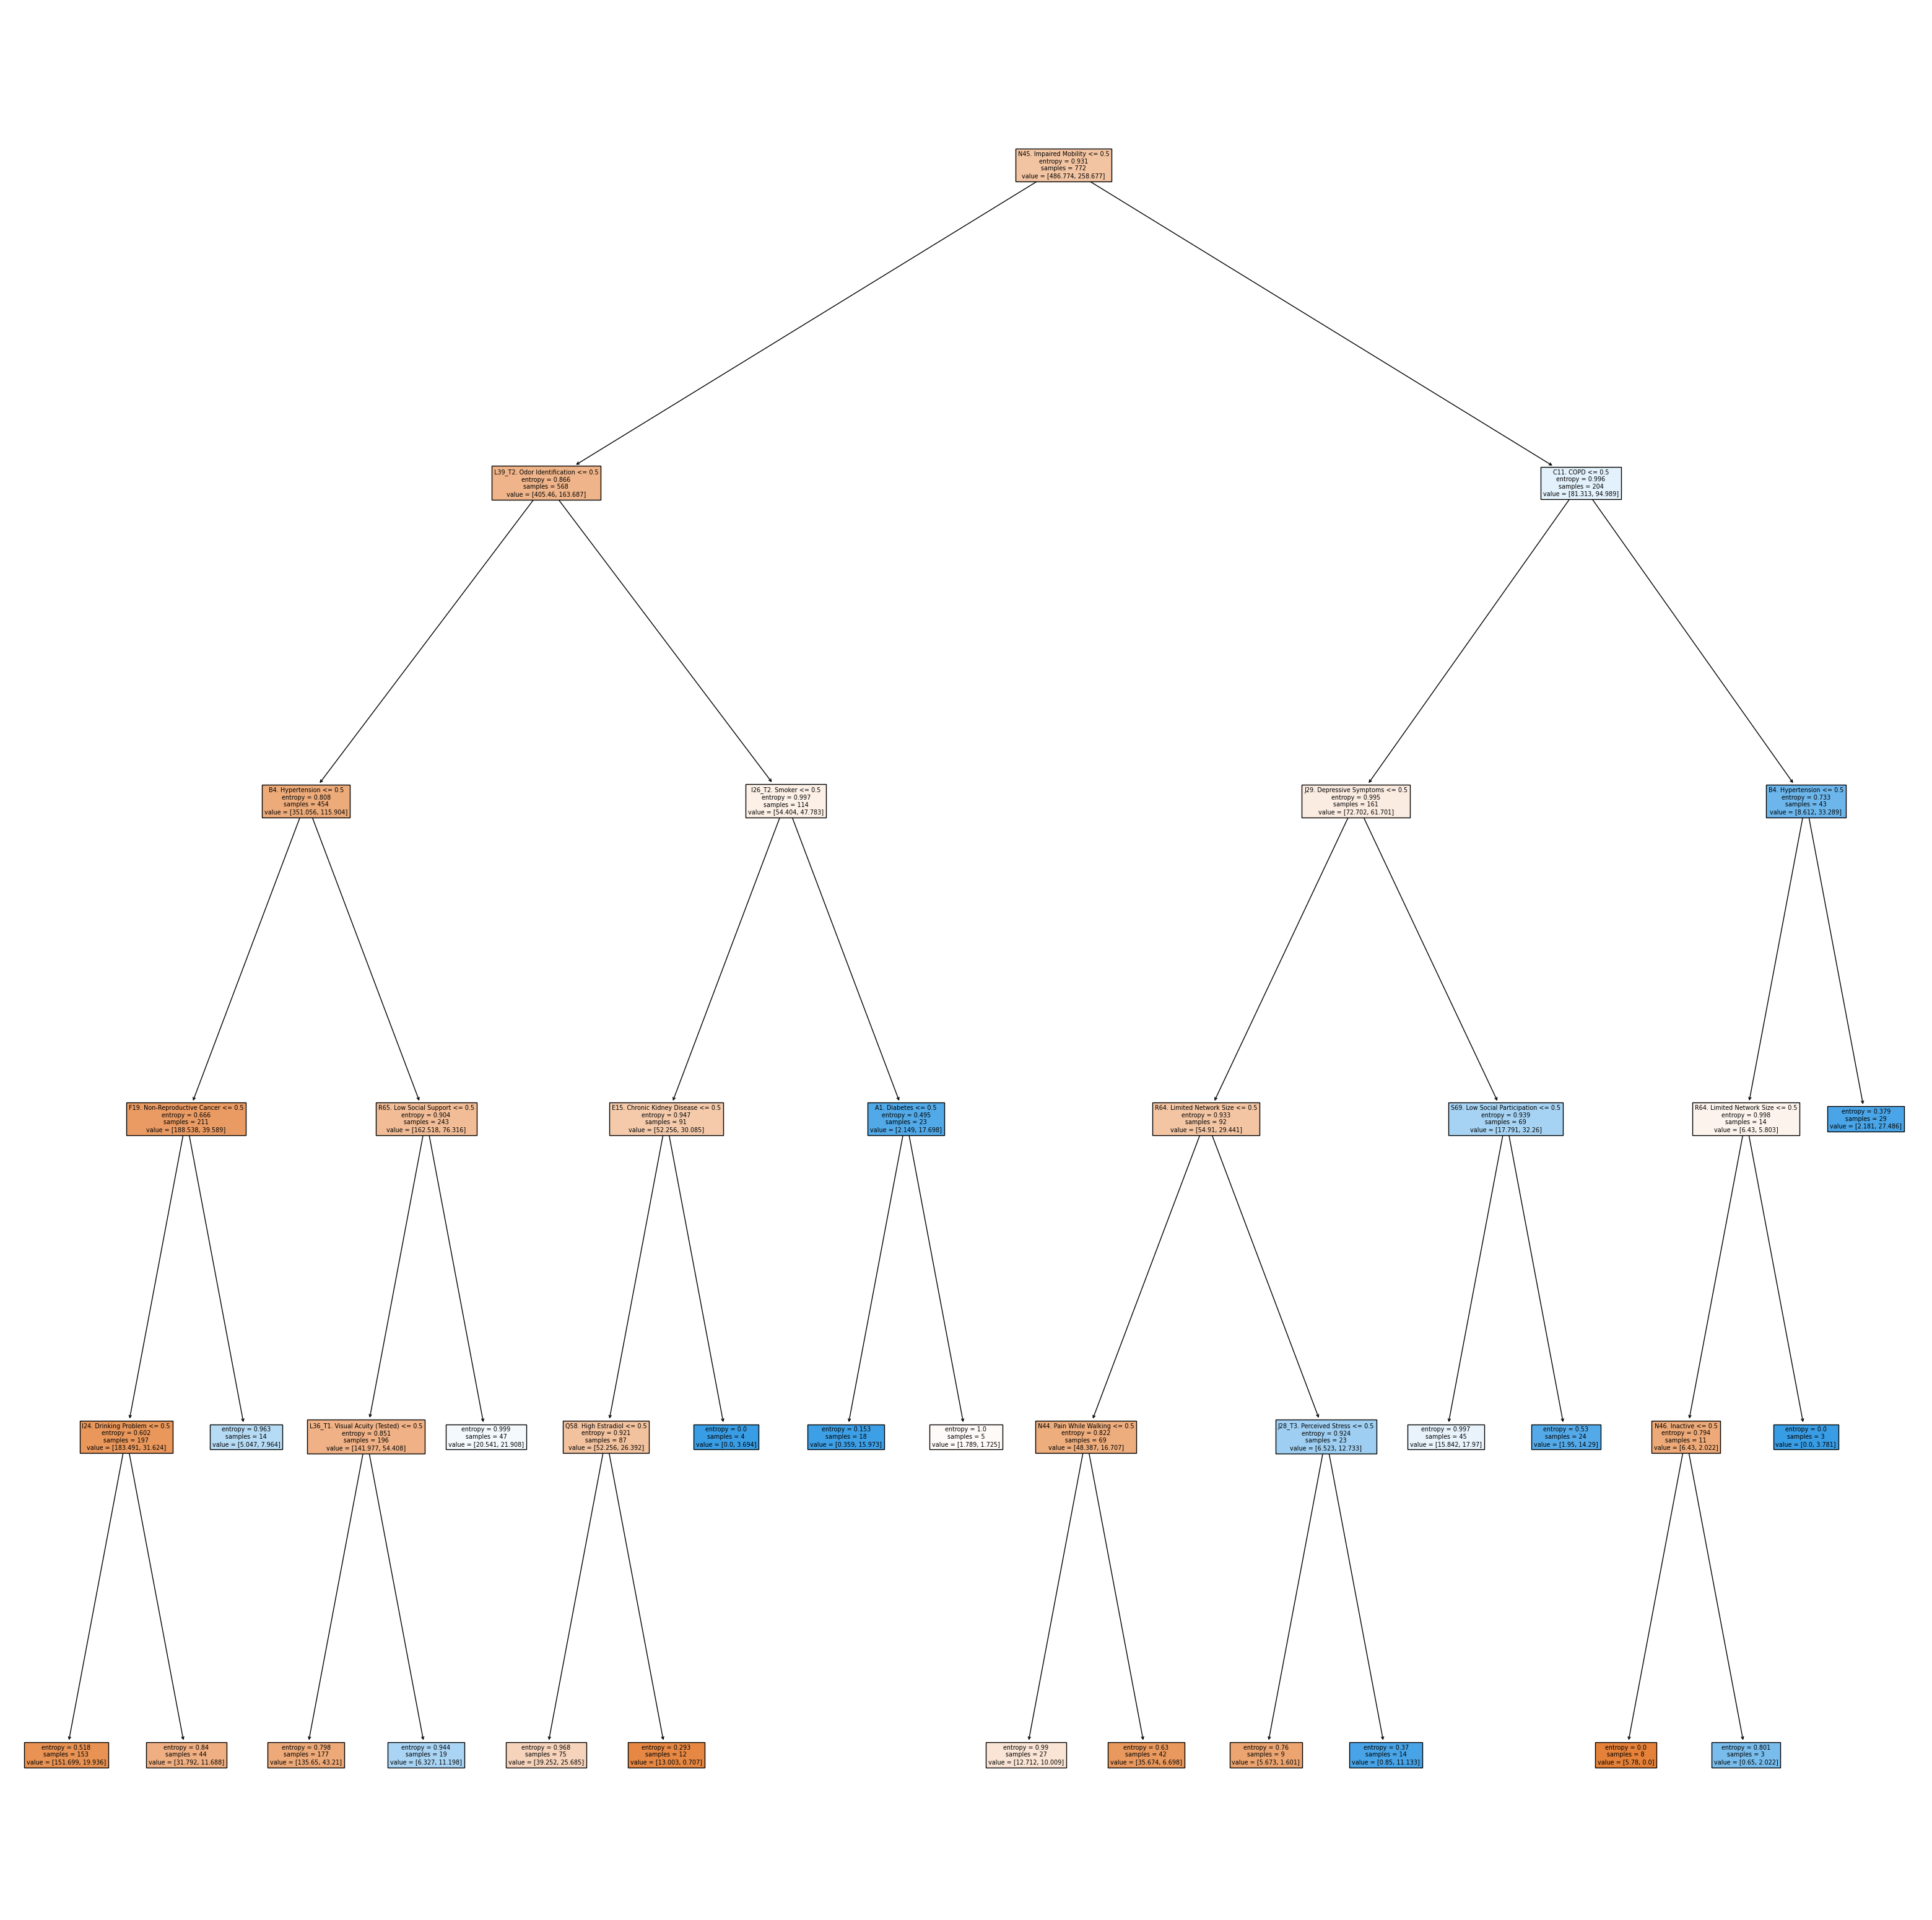

Performence on train set 0.7652336149459293
Performence on test set 0.7155070494331062
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80 118.97204345464706
         1.0       0.66      0.43      0.52 66.04934871196747

    accuracy                           0.72 185.02139216661453
   macro avg       0.69      0.65      0.66 185.02139216661453
weighted avg       0.71      0.72      0.70 185.02139216661453



In [65]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [77]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
6      0.0           0.0          1.0   
7      1.0           1.0          0.0   
12     1.0           0.0          0.0   
15     0.0           0.0          0.0   
18     1.0           1.0          0.0   
24     1.0           1.0          0.0   
29     1.0           0.0          0.0   
40     1.0           0.0          0.0   
48     1.0           0.0          1.0   
52     1.0           0.0          0.0   
53     1.0           1.0          0.0   
54     0.0           0.0          0.0   
59     1.0           0.0          0.0   
63     0.0           0.0          0.0   
64     1.0           0.0          0.0   
67     1.0           0.0          0.0   
72     0.0           1.0          0.0   
79     1.0           0.0          0.0   
80     0.0           0.0          0.0   
87     0.0           0.0          0.0   
89     1.0           0.0          0.0   
92     1.0           0.0          0.0   
95     1.0           0.0          0.0   
104    0.0           0.0          0.0   
108    1.0           0.0          0.0   
110    1.0           0.0          0.0   
130    1.0           0.0          0.0   
136    1.0           0.0          0.0   
143    1.0           0.0          0.0   
146    1.0           0.0          1.0   
150    0.0           0.0          0.0   
158    1.0           1.0          0.0   
161    1.0           1.0          0.0   
162    1.0           1.0          0.0   
166    0.0           1.0          0.0   
167    1.0           1.0          0.0   
171    0.0           0.0          0.0   
174    0.0           0.0          0.0   
175    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
6                                        0.0               1.0   
7                                        0.0               1.0   
12                                       0.0               0.0   
15                                       0.0               0.0   
18                                       0.0               1.0   
24                                       1.0               1.0   
29                                       0.0               0.0   
40                                       0.0               1.0   
48                                       0.0               1.0   
52                                       0.0               0.0   
53                                       0.0               0.0   
54                                       0.0               1.0   
59                                       0.0               1.0   
63                                       0.0               0.0   
64                                       1.0               0.0   
67                                       0.0               0.0   
72                                       1.0               1.0   
79                                       0.0               0.0   
80                                       0.0               1.0   
87                                       0.0               1.0   
89                                       0.0               1.0   
92                                       0.0               1.0   
95                                       0.0               0.0   
104                                      0.0               1.0   
108                                      0.0               1.0   
110                                      0.0               1.0   
130                                      0.0               0.0   
136                                      0.0               0.0   
143                                      0.0               1.0   
146                                      0.0               0.0   
150                                      0.0               1.0   
158                                      1.0               1.0   
161                                      0.0               1.0   
162                                      1.0               1.0   
166                                      0.0          

668


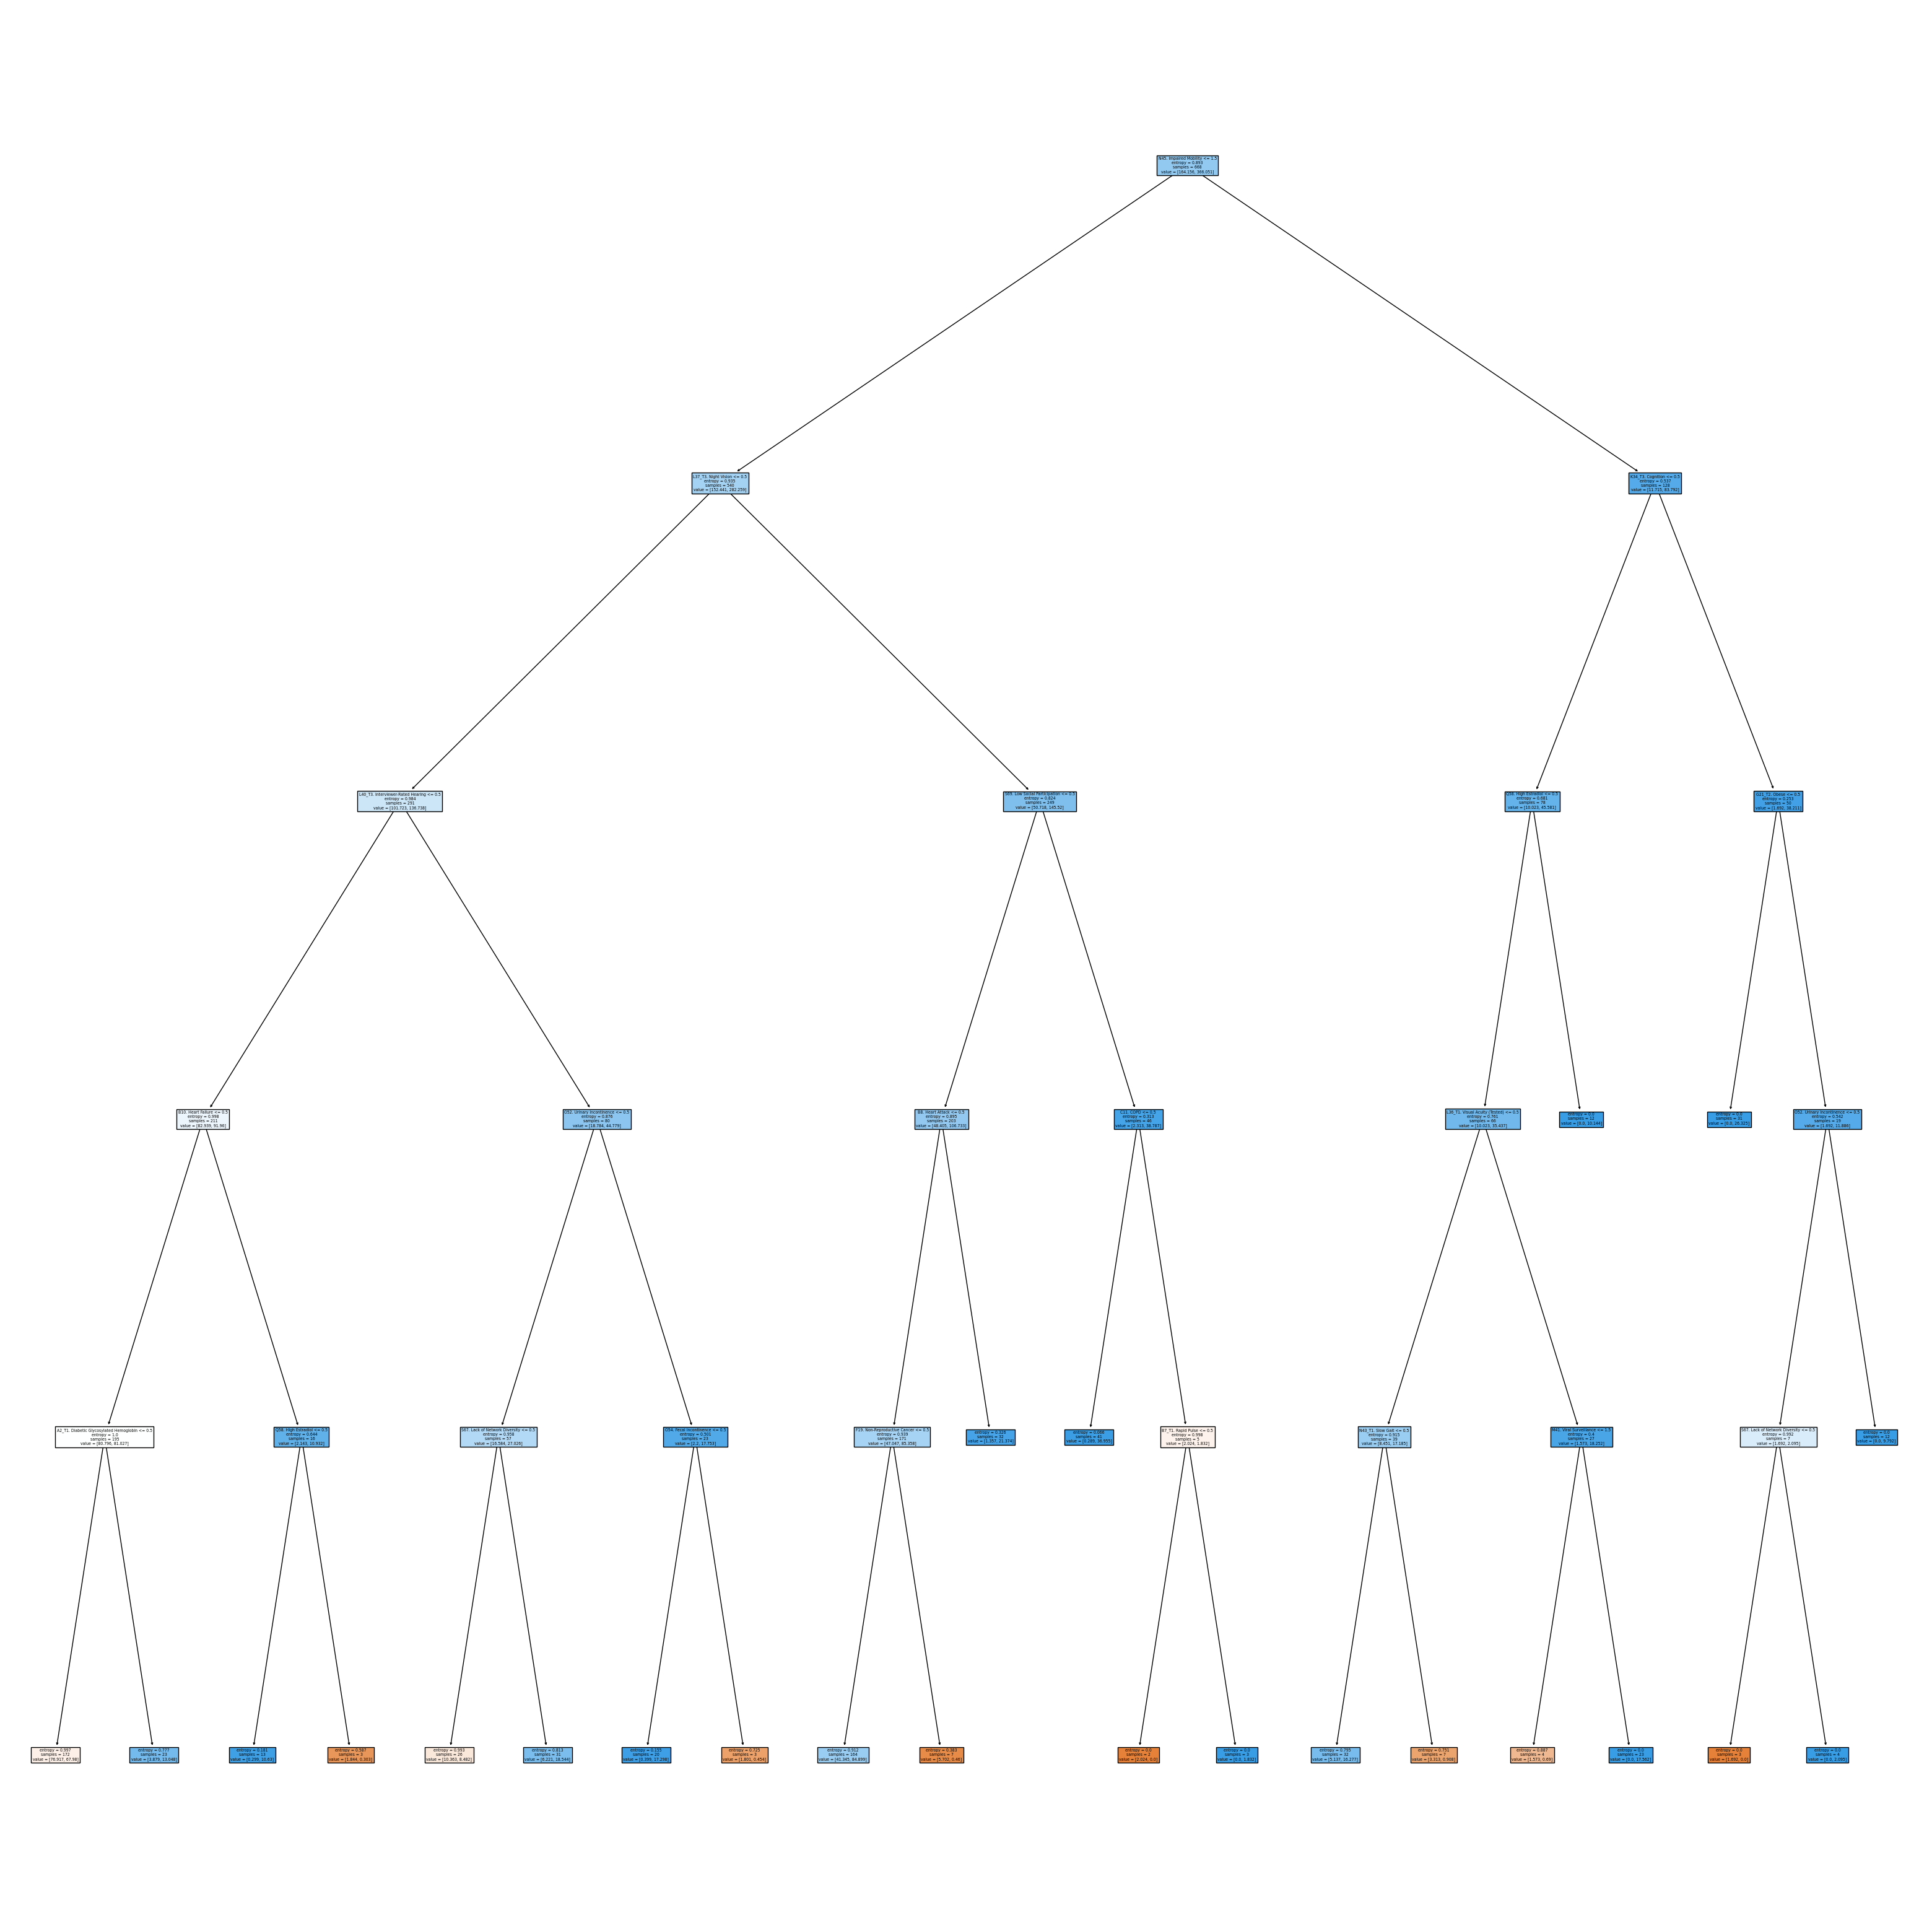

Performence on train set 0.7393398598040177
Performence on test set 0.5748699331284919
              precision    recall  f1-score   support

         0.0       0.32      0.38      0.35 42.218620002269745
         1.0       0.71      0.66      0.68 97.49572567641735

    accuracy                           0.57 139.7143456786871
   macro avg       0.52      0.52      0.52 139.7143456786871
weighted avg       0.59      0.57      0.58 139.7143456786871



In [78]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [79]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
1      1.0           0.0          0.0   
5      0.0           0.0          1.0   
7      1.0           0.0          0.0   
8      0.0           0.0          0.0   
9      1.0           0.0          0.0   
..     ...           ...          ...   
155    0.0           0.0          0.0   
156    1.0           0.0          0.0   
162    1.0           0.0          0.0   
166    1.0           0.0          0.0   
167    0.0           1.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
1                                        0.0               1.0   
5                                        0.0               1.0   
7                                        0.0               0.0   
8                                        0.0               1.0   
9                                        0.0               1.0   
..                                       ...               ...   
155                                      0.0               1.0   
156                                      0.0               1.0   
162                                      1.0               1.0   
166                                      0.0               1.0   
167                                      1.0               1.0   

     B8. Heart Attack  B9. Cerebrovascular Disease  B10. Heart Failure  \
1                 0.0                          0.0                 0.0   
5                 0.0                          0.0                 0.0   
7                 0.0                          0.0                 0.0   
8                 0.0                          0.0                 0.0   
9                 1.0                          0.0                 0.0   
..                ...                          ...                 ...   
155               0.0                          0.0                 0.0   
156               0.0                          0.0                 0.0   
162               0.0                          0.0                 1.0   
166               0.0                          0.0                 0.0   
167               0.0                          0.0                 0.0   

     BT_T2. Systolic Blood Pressure  B6_T2. Diastolic Blood Pressure  ...  \
1                               0.0                              0.0  ...   
5                               0.0                              0.0  ...   
7                               0.0                              0.0  ...   
8                               0.0                              0.0  ...   
9                               0.0                              0.0  ...   
..                              ...                              ...  ...   
155                             1.0                              0.0  ...   
156                             0.0                              0.0  ...   
162                             0.0                              0.0  ...   
166                             1.0                              0.0  ...   
167                             0.0                              0.0  ...   

     Q57. Low Testosterone  Q58. High Estradiol  Q59. Low/High Progesterone  \
1                      0.0                  0.0                         0.0   
5                      0.0                  1.0                         1.0   
7                      0.0                  0.0                         0.0   
8                      0.0                  1.0                         0.0   
9                      0.0                  1.0                         0.0   
..                     ...                  ...                         ...   
155                    0.0                  0.0                         0.0   
156                    1.0                  0.0                         1.0   
162                    0.0                  0.0                         0.0   
166                    0.0                  0.0                         0.0   
167                    1.0          

## Education

504


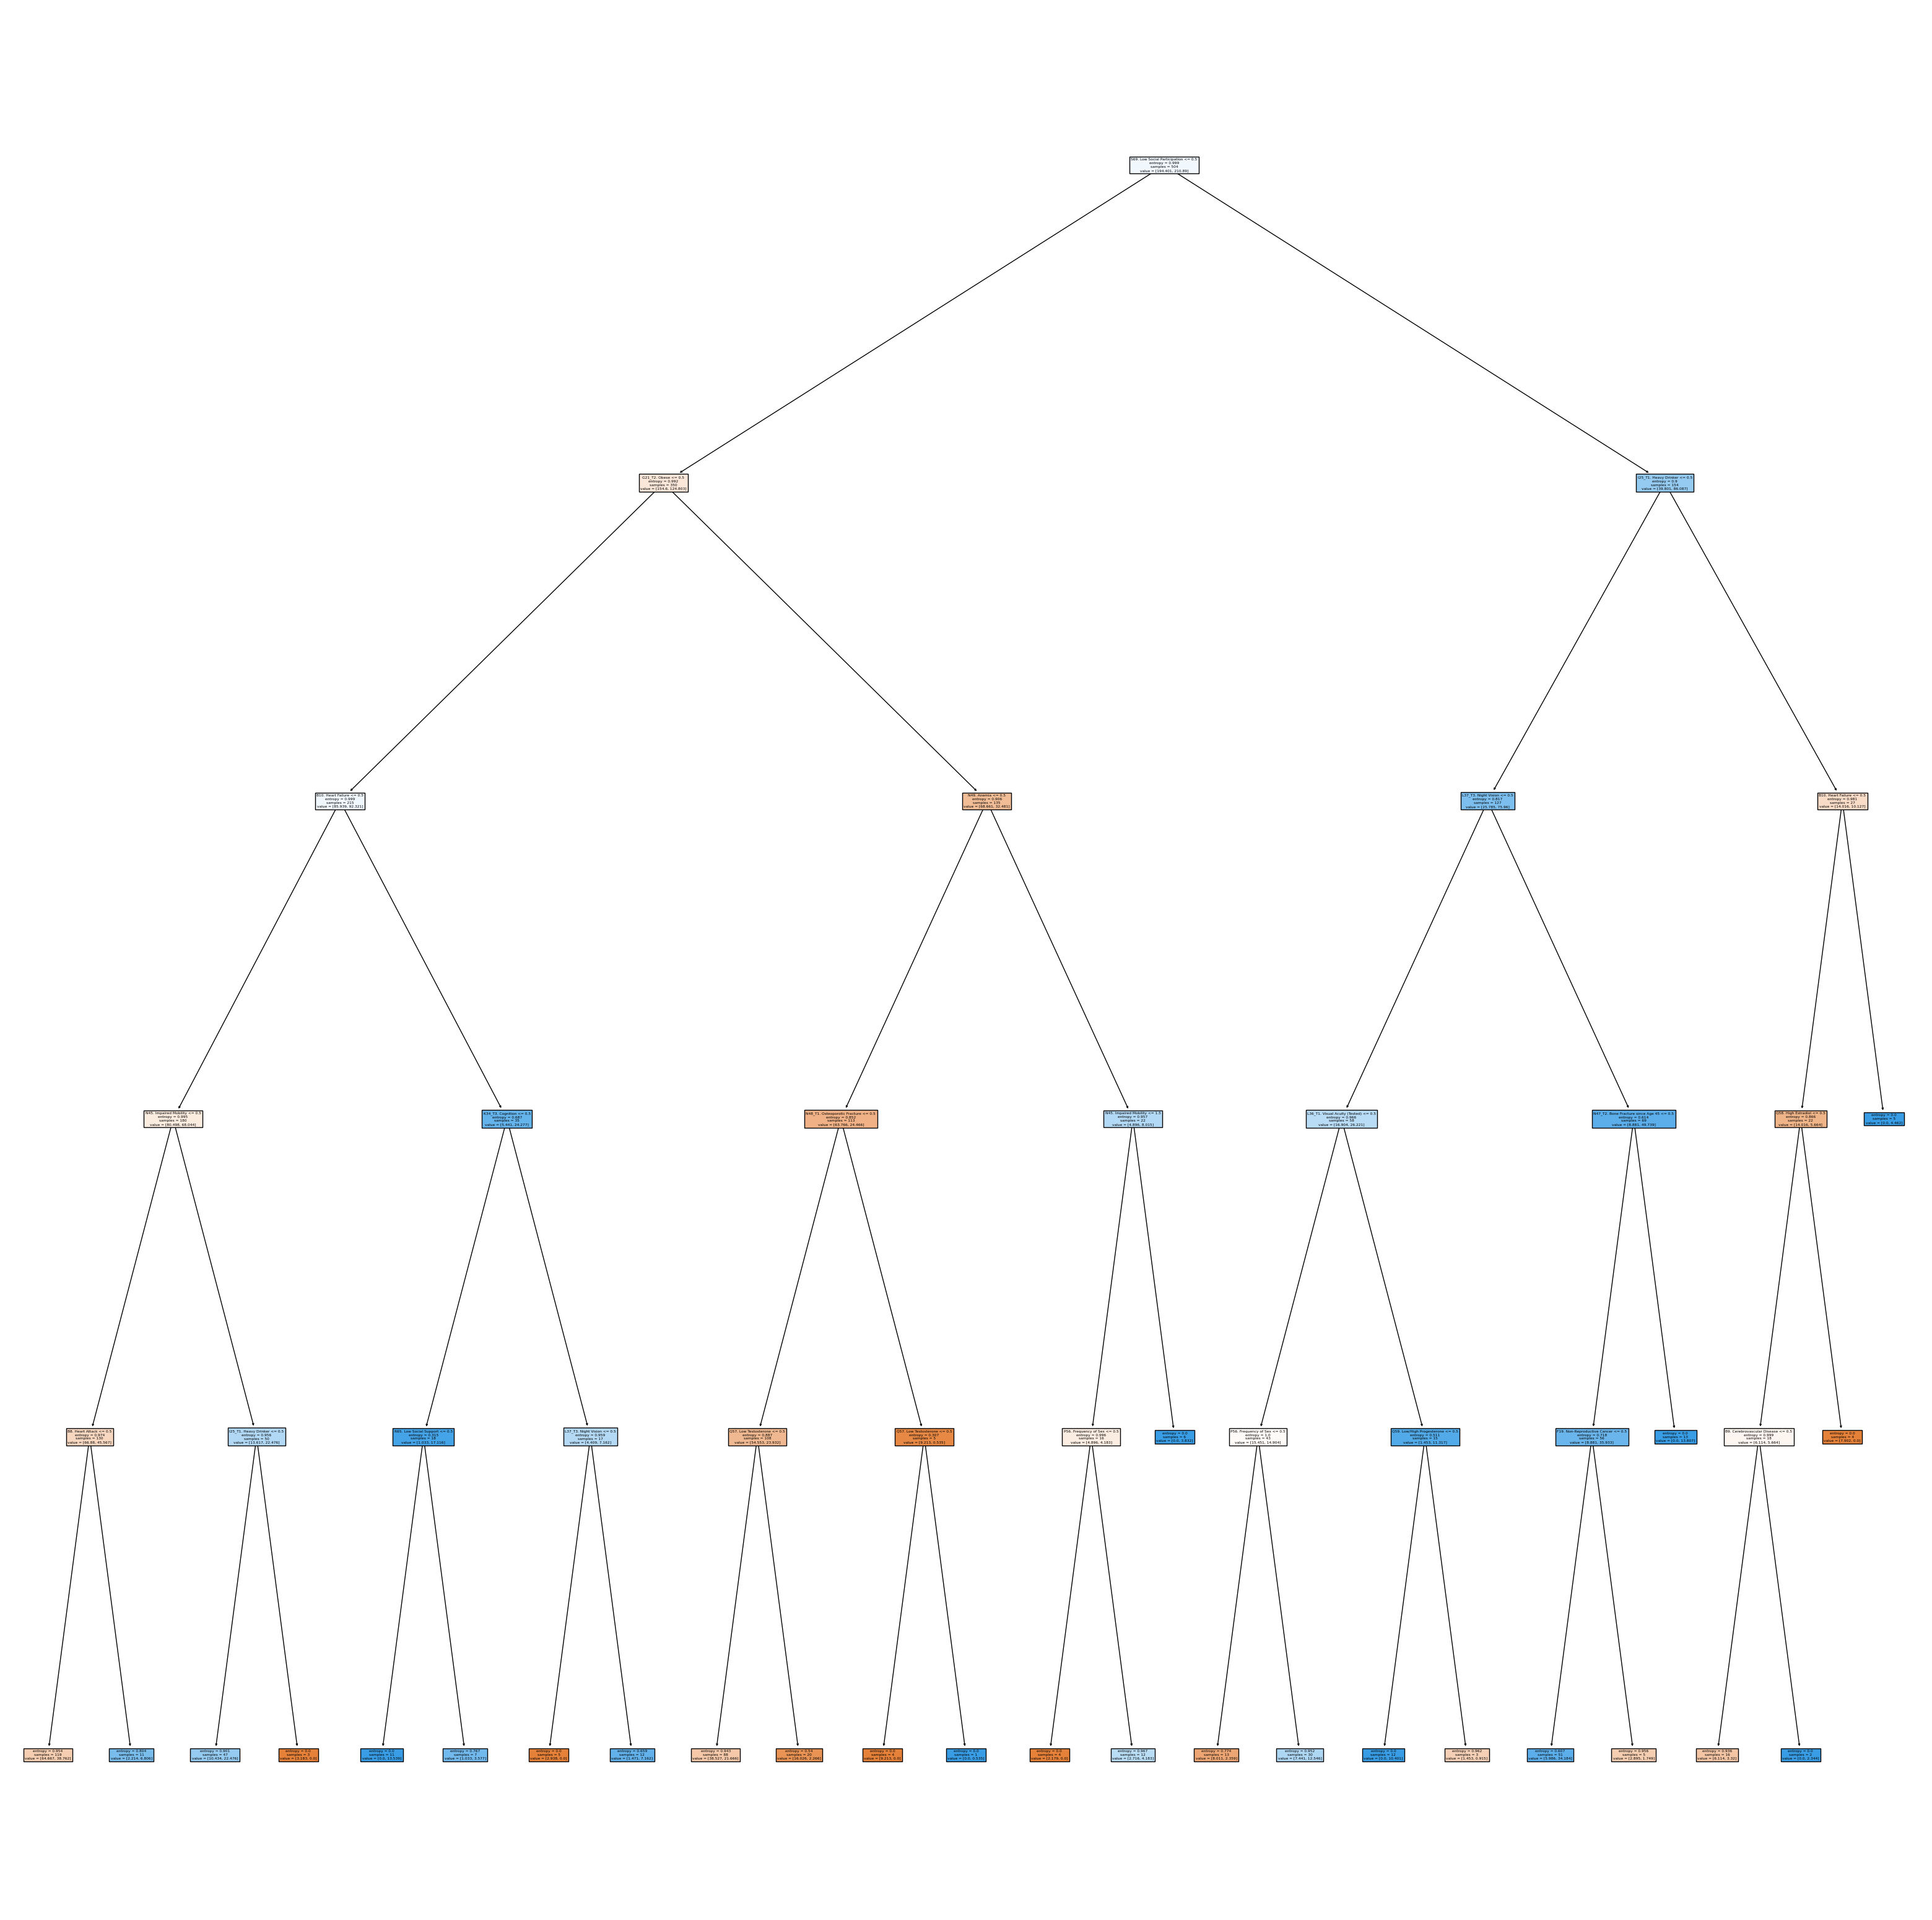

Performence on train set 0.7475132545576354
Performence on test set 0.5675506819286759
              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58 43.87557354569435
         1.0       0.63      0.49      0.55 51.97785663604736

    accuracy                           0.57 95.85343018174171
   macro avg       0.58      0.57      0.57 95.85343018174171
weighted avg       0.58      0.57      0.57 95.85343018174171



In [82]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [83]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
2      1.0           0.0          0.0   
3      1.0           0.0          0.0   
4      1.0           0.0          0.0   
5      1.0           0.0          1.0   
7      1.0           1.0          1.0   
8      0.0           0.0          0.0   
12     0.0           1.0          0.0   
13     0.0           0.0          0.0   
16     0.0           0.0          0.0   
17     0.0           0.0          1.0   
23     1.0           0.0          0.0   
25     0.0           0.0          0.0   
27     0.0           0.0          0.0   
29     0.0           1.0          0.0   
32     1.0           0.0          0.0   
37     1.0           0.0          0.0   
40     0.0           0.0          0.0   
45     1.0           0.0          0.0   
46     1.0           0.0          0.0   
49     1.0           0.0          1.0   
52     1.0           0.0          0.0   
55     1.0           1.0          0.0   
57     1.0           1.0          0.0   
58     1.0           0.0          0.0   
59     0.0           0.0          1.0   
61     1.0           1.0          0.0   
62     1.0           1.0          0.0   
64     1.0           1.0          0.0   
68     1.0           0.0          0.0   
69     1.0           0.0          0.0   
72     0.0           0.0          1.0   
73     0.0           1.0          0.0   
74     0.0           0.0          0.0   
78     1.0           0.0          0.0   
82     1.0           0.0          0.0   
84     1.0           0.0          0.0   
85     1.0           0.0          0.0   
89     1.0           1.0          0.0   
90     0.0           1.0          0.0   
91     1.0           0.0          0.0   
95     1.0           0.0          0.0   
97     1.0           0.0          0.0   
103    0.0           1.0          0.0   
108    0.0           1.0          0.0   
109    0.0           0.0          0.0   
113    0.0           0.0          0.0   
115    1.0           0.0          0.0   
116    1.0           1.0          0.0   
118    1.0           1.0          1.0   
119    0.0           1.0          0.0   
120    1.0           1.0          0.0   
121    0.0           0.0          0.0   
122    1.0           1.0          0.0   
123    1.0           0.0          0.0   
124    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
2                                        0.0               0.0   
3                                        0.0               1.0   
4                                        0.0               1.0   
5                                        0.0               1.0   
7                                        0.0               1.0   
8                                        0.0               1.0   
12                                       1.0               1.0   
13                                       1.0               1.0   
16                                       1.0               1.0   
17                                       0.0               1.0   
23                                       0.0               0.0   
25                                       0.0               1.0   
27                                       0.0               0.0   
29                                       1.0               1.0   
32                                       0.0               0.0   
37                                       0.0               1.0   
40                                       0.0               0.0   
45                                       0.0               0.0   
46                                       0.0               0.0   
49                                       0.0               0.0   
52                                       0.0               1.0   
55                                       0.0               1.0   
57                                       1.0               1.0   
58                                       0.0               1.0   
59                                       0.0              

563


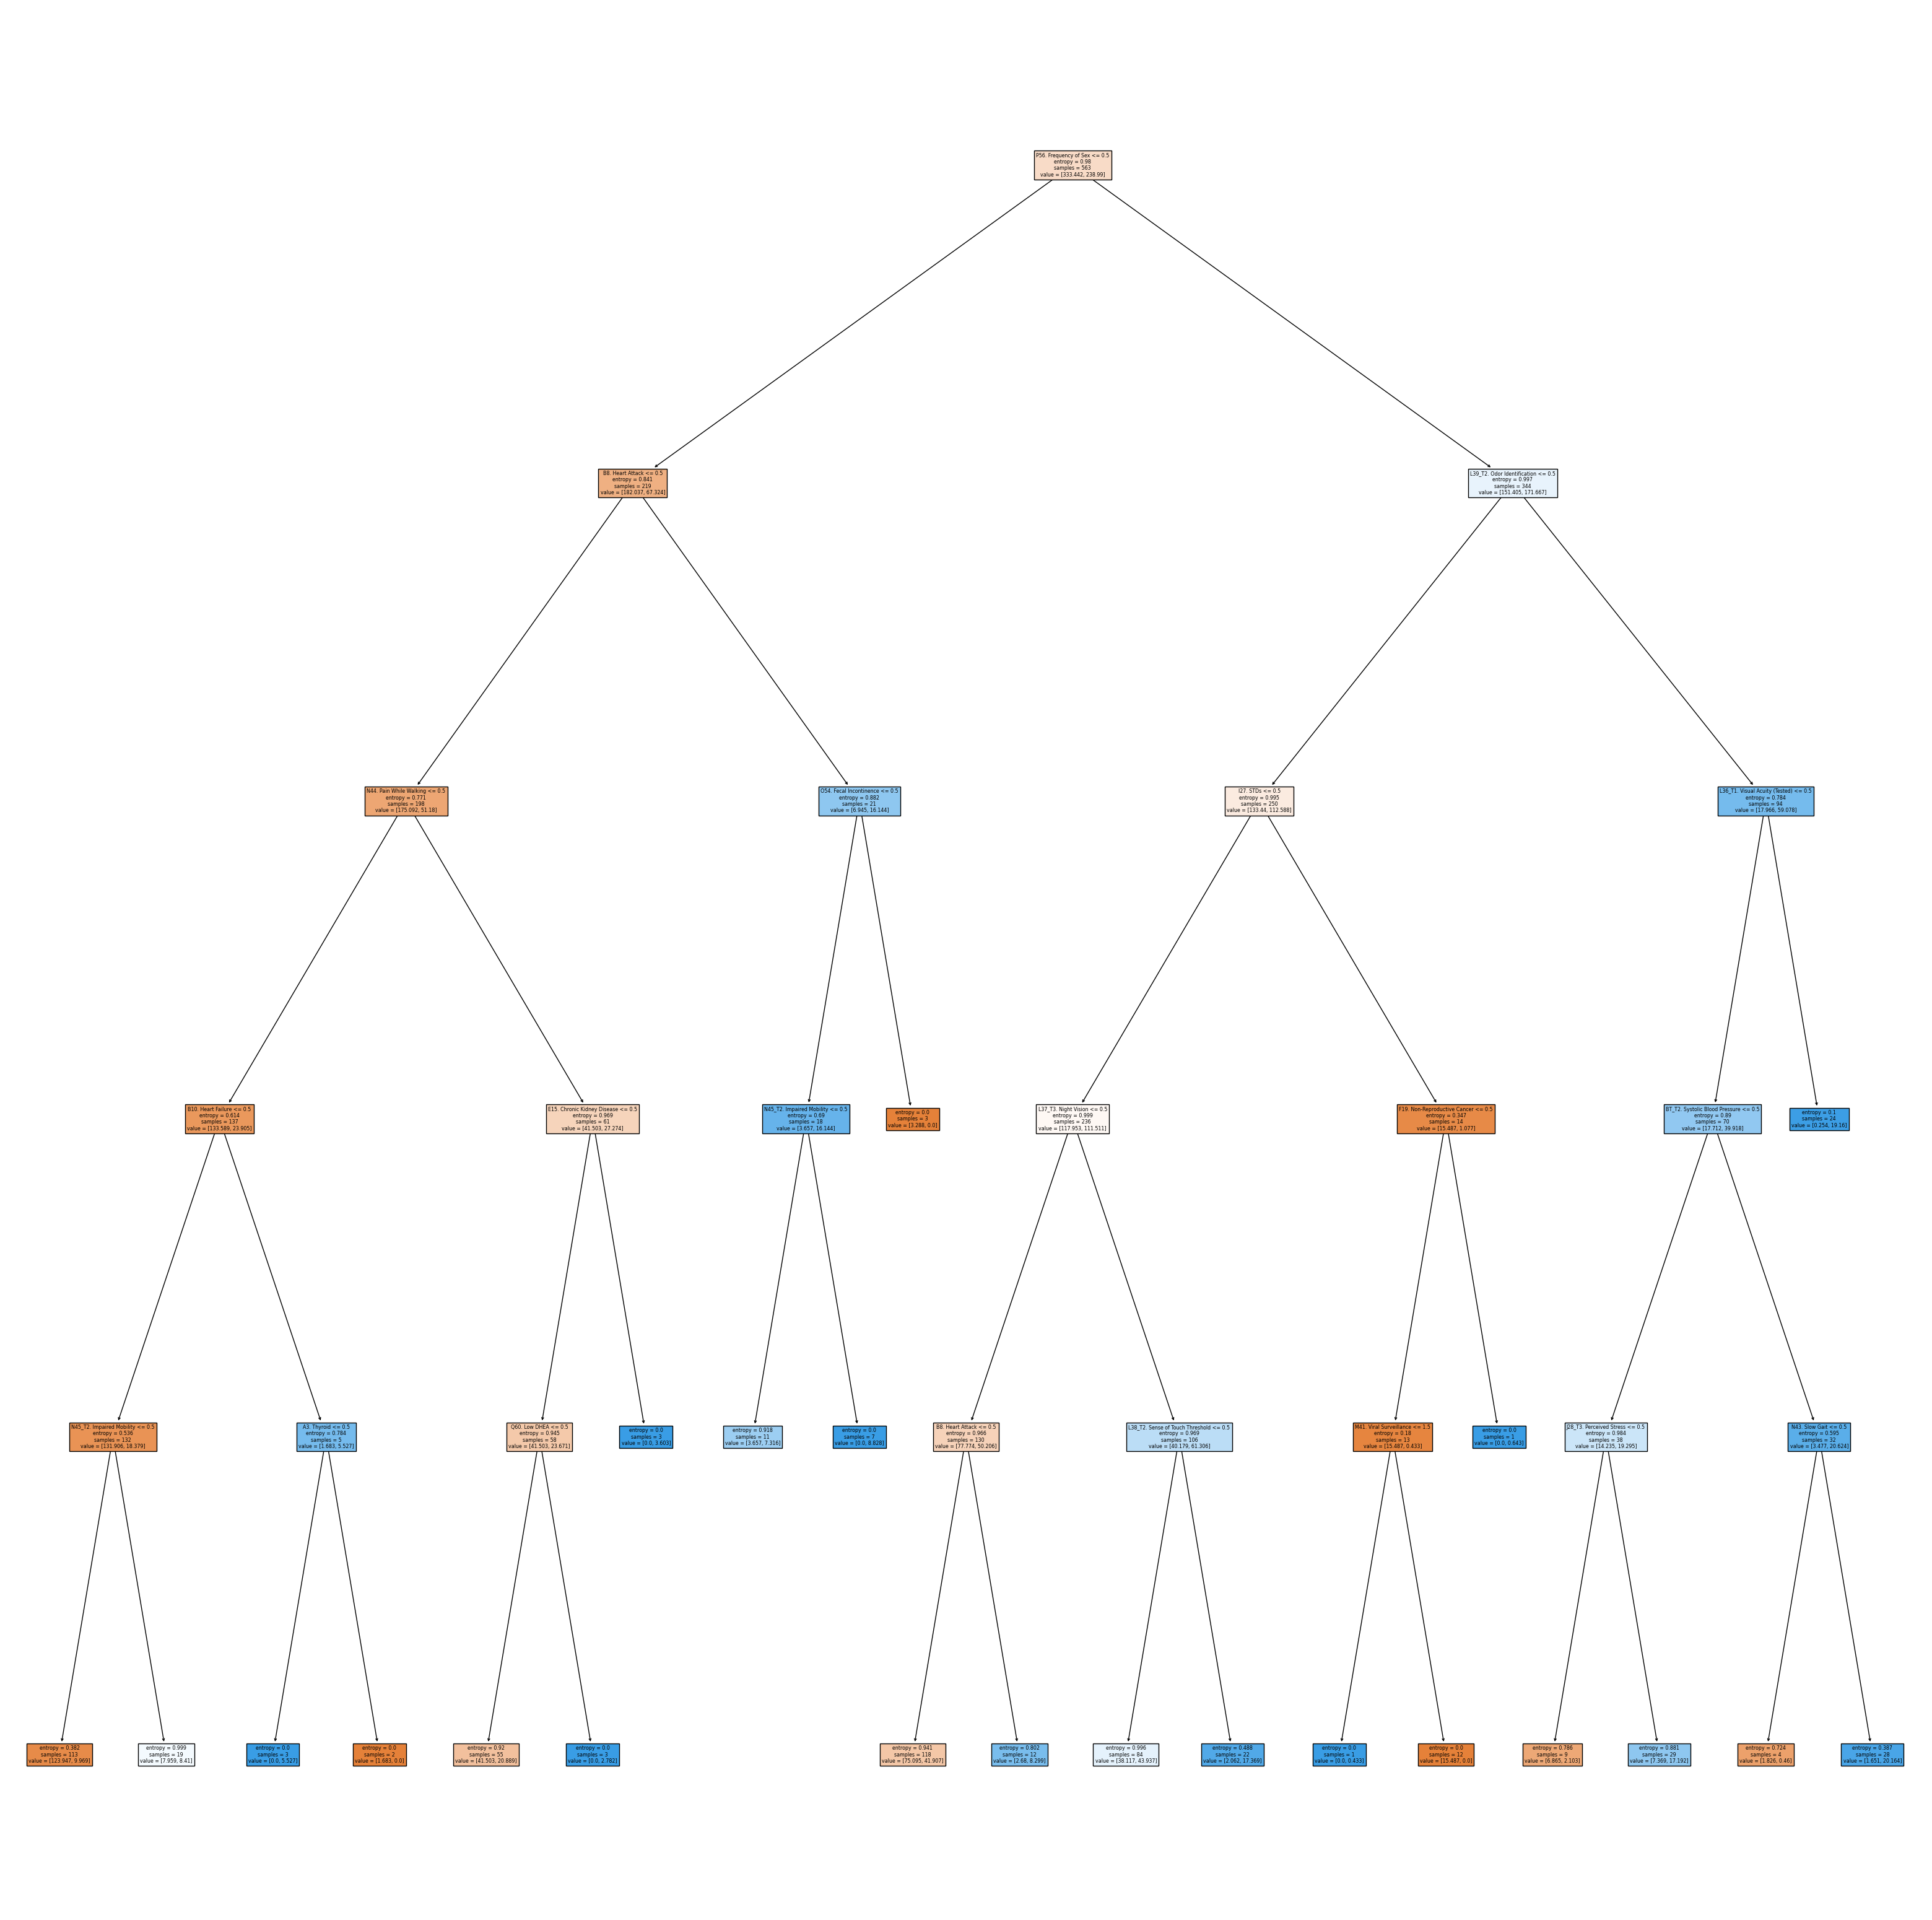

Performence on train set 0.7570455336916587
Performence on test set 0.6532853581223288
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71 83.41197308897972
         1.0       0.57      0.58      0.58 56.449920907616615

    accuracy                           0.65 139.86189399659634
   macro avg       0.64      0.64      0.64 139.86189399659634
weighted avg       0.65      0.65      0.65 139.86189399659634



In [84]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [85]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
0      1.0           1.0          1.0   
22     0.0           0.0          0.0   
24     1.0           0.0          0.0   
25     1.0           0.0          0.0   
26     0.0           0.0          1.0   
29     1.0           0.0          0.0   
31     0.0           0.0          0.0   
32     1.0           0.0          0.0   
35     1.0           1.0          0.0   
37     1.0           0.0          0.0   
40     1.0           1.0          1.0   
42     0.0           0.0          0.0   
44     1.0           1.0          0.0   
48     0.0           0.0          0.0   
49     0.0           0.0          0.0   
50     0.0           0.0          0.0   
51     0.0           0.0          0.0   
53     1.0           0.0          0.0   
56     1.0           1.0          0.0   
59     1.0           0.0          1.0   
60     1.0           0.0          1.0   
63     0.0           0.0          0.0   
64     0.0           1.0          0.0   
69     1.0           1.0          0.0   
70     1.0           0.0          1.0   
76     1.0           0.0          0.0   
81     1.0           0.0          0.0   
82     1.0           0.0          0.0   
87     0.0           0.0          0.0   
89     1.0           0.0          0.0   
95     1.0           0.0          0.0   
99     0.0           0.0          0.0   
100    0.0           0.0          0.0   
102    0.0           0.0          0.0   
104    1.0           0.0          0.0   
105    0.0           0.0          1.0   
106    1.0           0.0          0.0   
112    0.0           0.0          0.0   
113    0.0           0.0          0.0   
114    1.0           0.0          0.0   
118    1.0           1.0          0.0   
119    1.0           0.0          1.0   
124    1.0           1.0          1.0   
125    0.0           0.0          0.0   
128    0.0           0.0          0.0   
132    0.0           0.0          0.0   
140    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
0                                        0.0               1.0   
22                                       0.0               0.0   
24                                       0.0               1.0   
25                                       0.0               1.0   
26                                       0.0               0.0   
29                                       0.0               1.0   
31                                       1.0               1.0   
32                                       0.0               0.0   
35                                       0.0               1.0   
37                                       0.0               0.0   
40                                       0.0               0.0   
42                                       0.0               0.0   
44                                       1.0               1.0   
48                                       0.0               1.0   
49                                       0.0               0.0   
50                                       0.0               1.0   
51                                       0.0               0.0   
53                                       0.0               0.0   
56                                       1.0               1.0   
59                                       0.0               0.0   
60                                       0.0               0.0   
63                                       0.0               1.0   
64                                       0.0               1.0   
69                                       1.0               0.0   
70                                       0.0               1.0   
76                                       0.0               1.0   
81                                       0.0               1.0   
82                                       0.0               1.0   
87                                       0.0               1.0   
89                                       1.0            

610


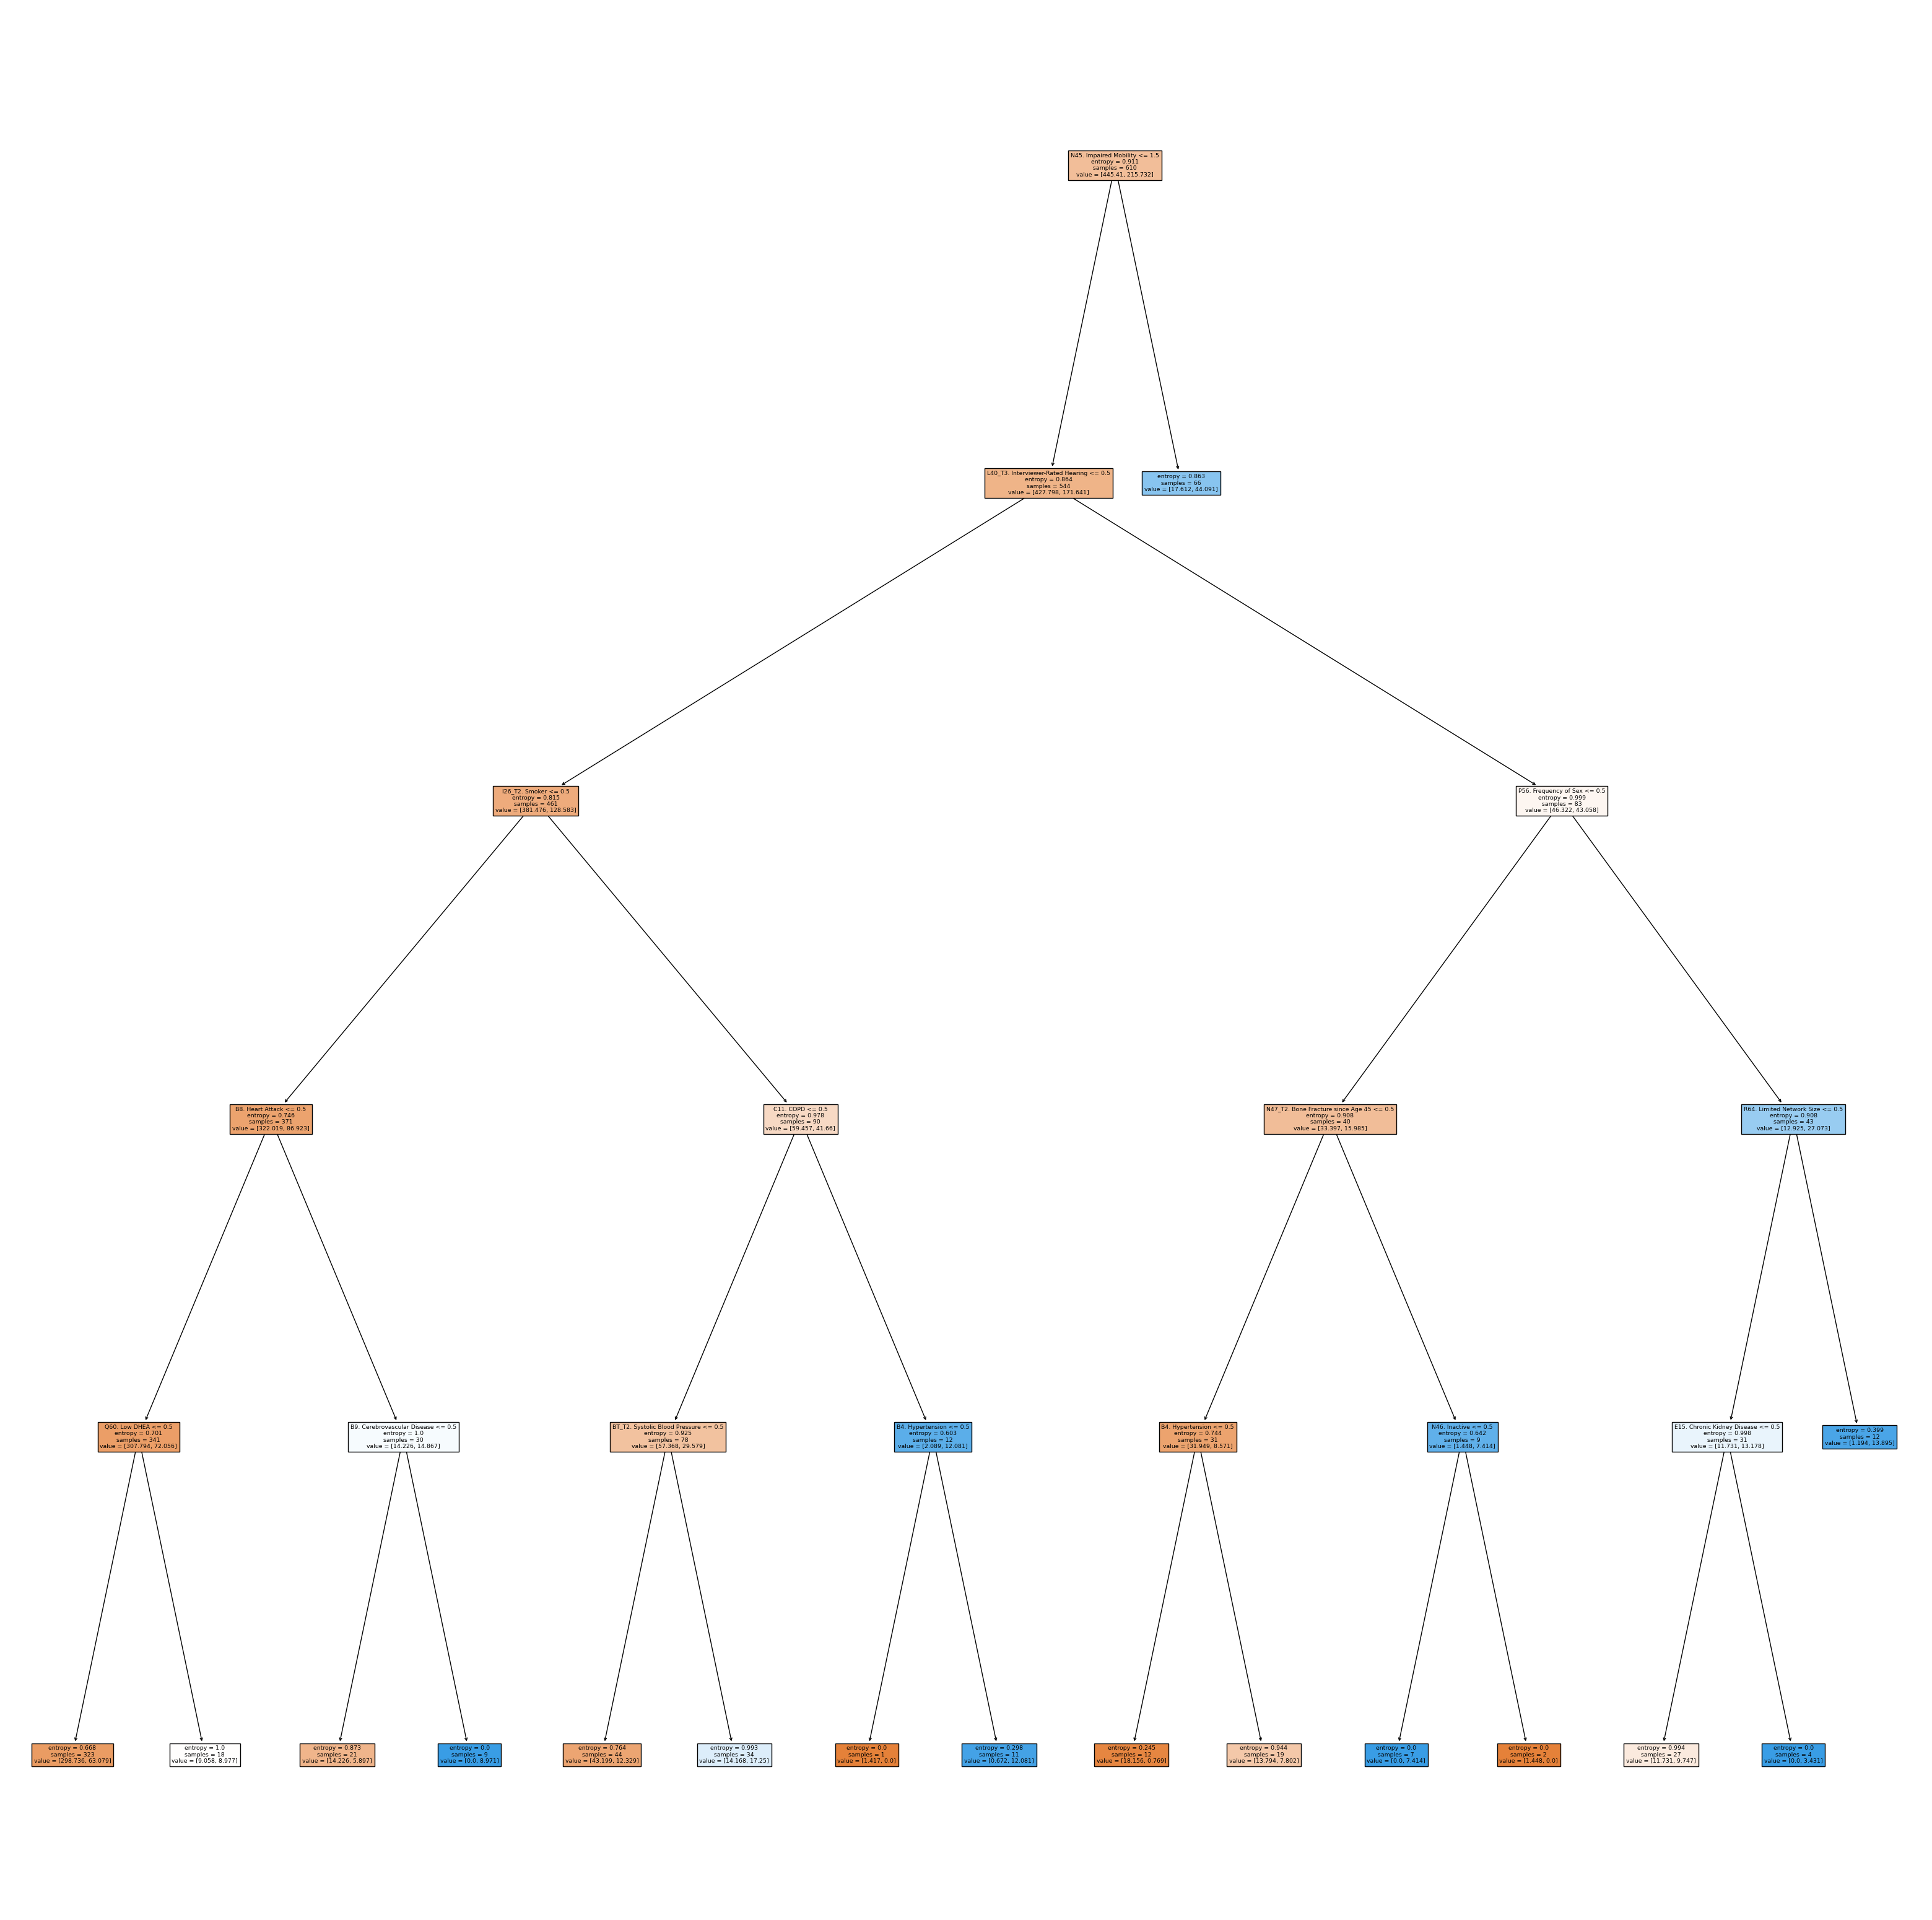

Performence on train set 0.7848489767323632
Performence on test set 0.6796493750539122
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78 103.80248741805553
         1.0       0.51      0.31      0.39 50.09538099169731

    accuracy                           0.68 153.89786840975285
   macro avg       0.62      0.58      0.58 153.89786840975285
weighted avg       0.65      0.68      0.65 153.89786840975285



In [86]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [87]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
11     1.0           0.0          0.0   
14     0.0           0.0          1.0   
18     1.0           0.0          1.0   
20     1.0           0.0          0.0   
25     1.0           0.0          0.0   
27     0.0           0.0          0.0   
29     1.0           1.0          0.0   
31     0.0           0.0          0.0   
32     1.0           0.0          0.0   
36     1.0           1.0          0.0   
38     1.0           1.0          0.0   
39     0.0           1.0          0.0   
40     1.0           0.0          0.0   
41     1.0           0.0          0.0   
49     1.0           0.0          0.0   
51     1.0           0.0          0.0   
52     1.0           0.0          1.0   
55     0.0           1.0          0.0   
59     1.0           0.0          0.0   
61     1.0           0.0          0.0   
62     0.0           1.0          0.0   
65     1.0           1.0          0.0   
70     1.0           1.0          0.0   
72     1.0           0.0          0.0   
77     1.0           0.0          0.0   
81     1.0           0.0          1.0   
83     1.0           0.0          0.0   
87     0.0           1.0          0.0   
94     0.0           0.0          0.0   
95     0.0           0.0          0.0   
97     1.0           1.0          0.0   
100    1.0           1.0          0.0   
103    1.0           0.0          0.0   
104    1.0           0.0          0.0   
106    1.0           0.0          1.0   
107    1.0           1.0          0.0   
109    1.0           1.0          0.0   
116    1.0           0.0          1.0   
117    1.0           1.0          0.0   
121    0.0           0.0          0.0   
122    1.0           0.0          0.0   
123    1.0           0.0          1.0   
125    0.0           0.0          0.0   
127    1.0           0.0          0.0   
129    1.0           0.0          0.0   
133    1.0           0.0          0.0   
135    1.0           0.0          0.0   
137    1.0           0.0          1.0   
138    0.0           0.0          1.0   
139    0.0           0.0          0.0   
140    1.0           0.0          0.0   
146    0.0           0.0          1.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
11                                       0.0               1.0   
14                                       0.0               0.0   
18                                       0.0               1.0   
20                                       0.0               0.0   
25                                       0.0               0.0   
27                                       0.0               1.0   
29                                       1.0               1.0   
31                                       0.0               1.0   
32                                       0.0               1.0   
36                                       1.0               0.0   
38                                       0.0               1.0   
39                                       1.0               1.0   
40                                       0.0               0.0   
41                                       0.0               1.0   
49                                       0.0               0.0   
51                                       0.0               1.0   
52                                       0.0               1.0   
55                                       0.0               1.0   
59                                       0.0               1.0   
61                                       0.0               0.0   
62                                       0.0               1.0   
65                                       0.0               0.0   
70                                       1.0               1.0   
72                                       0.0               1.0   
77                                       0.0               0.0   
81                                       0.0               1.0   
83                                       0.0     

468


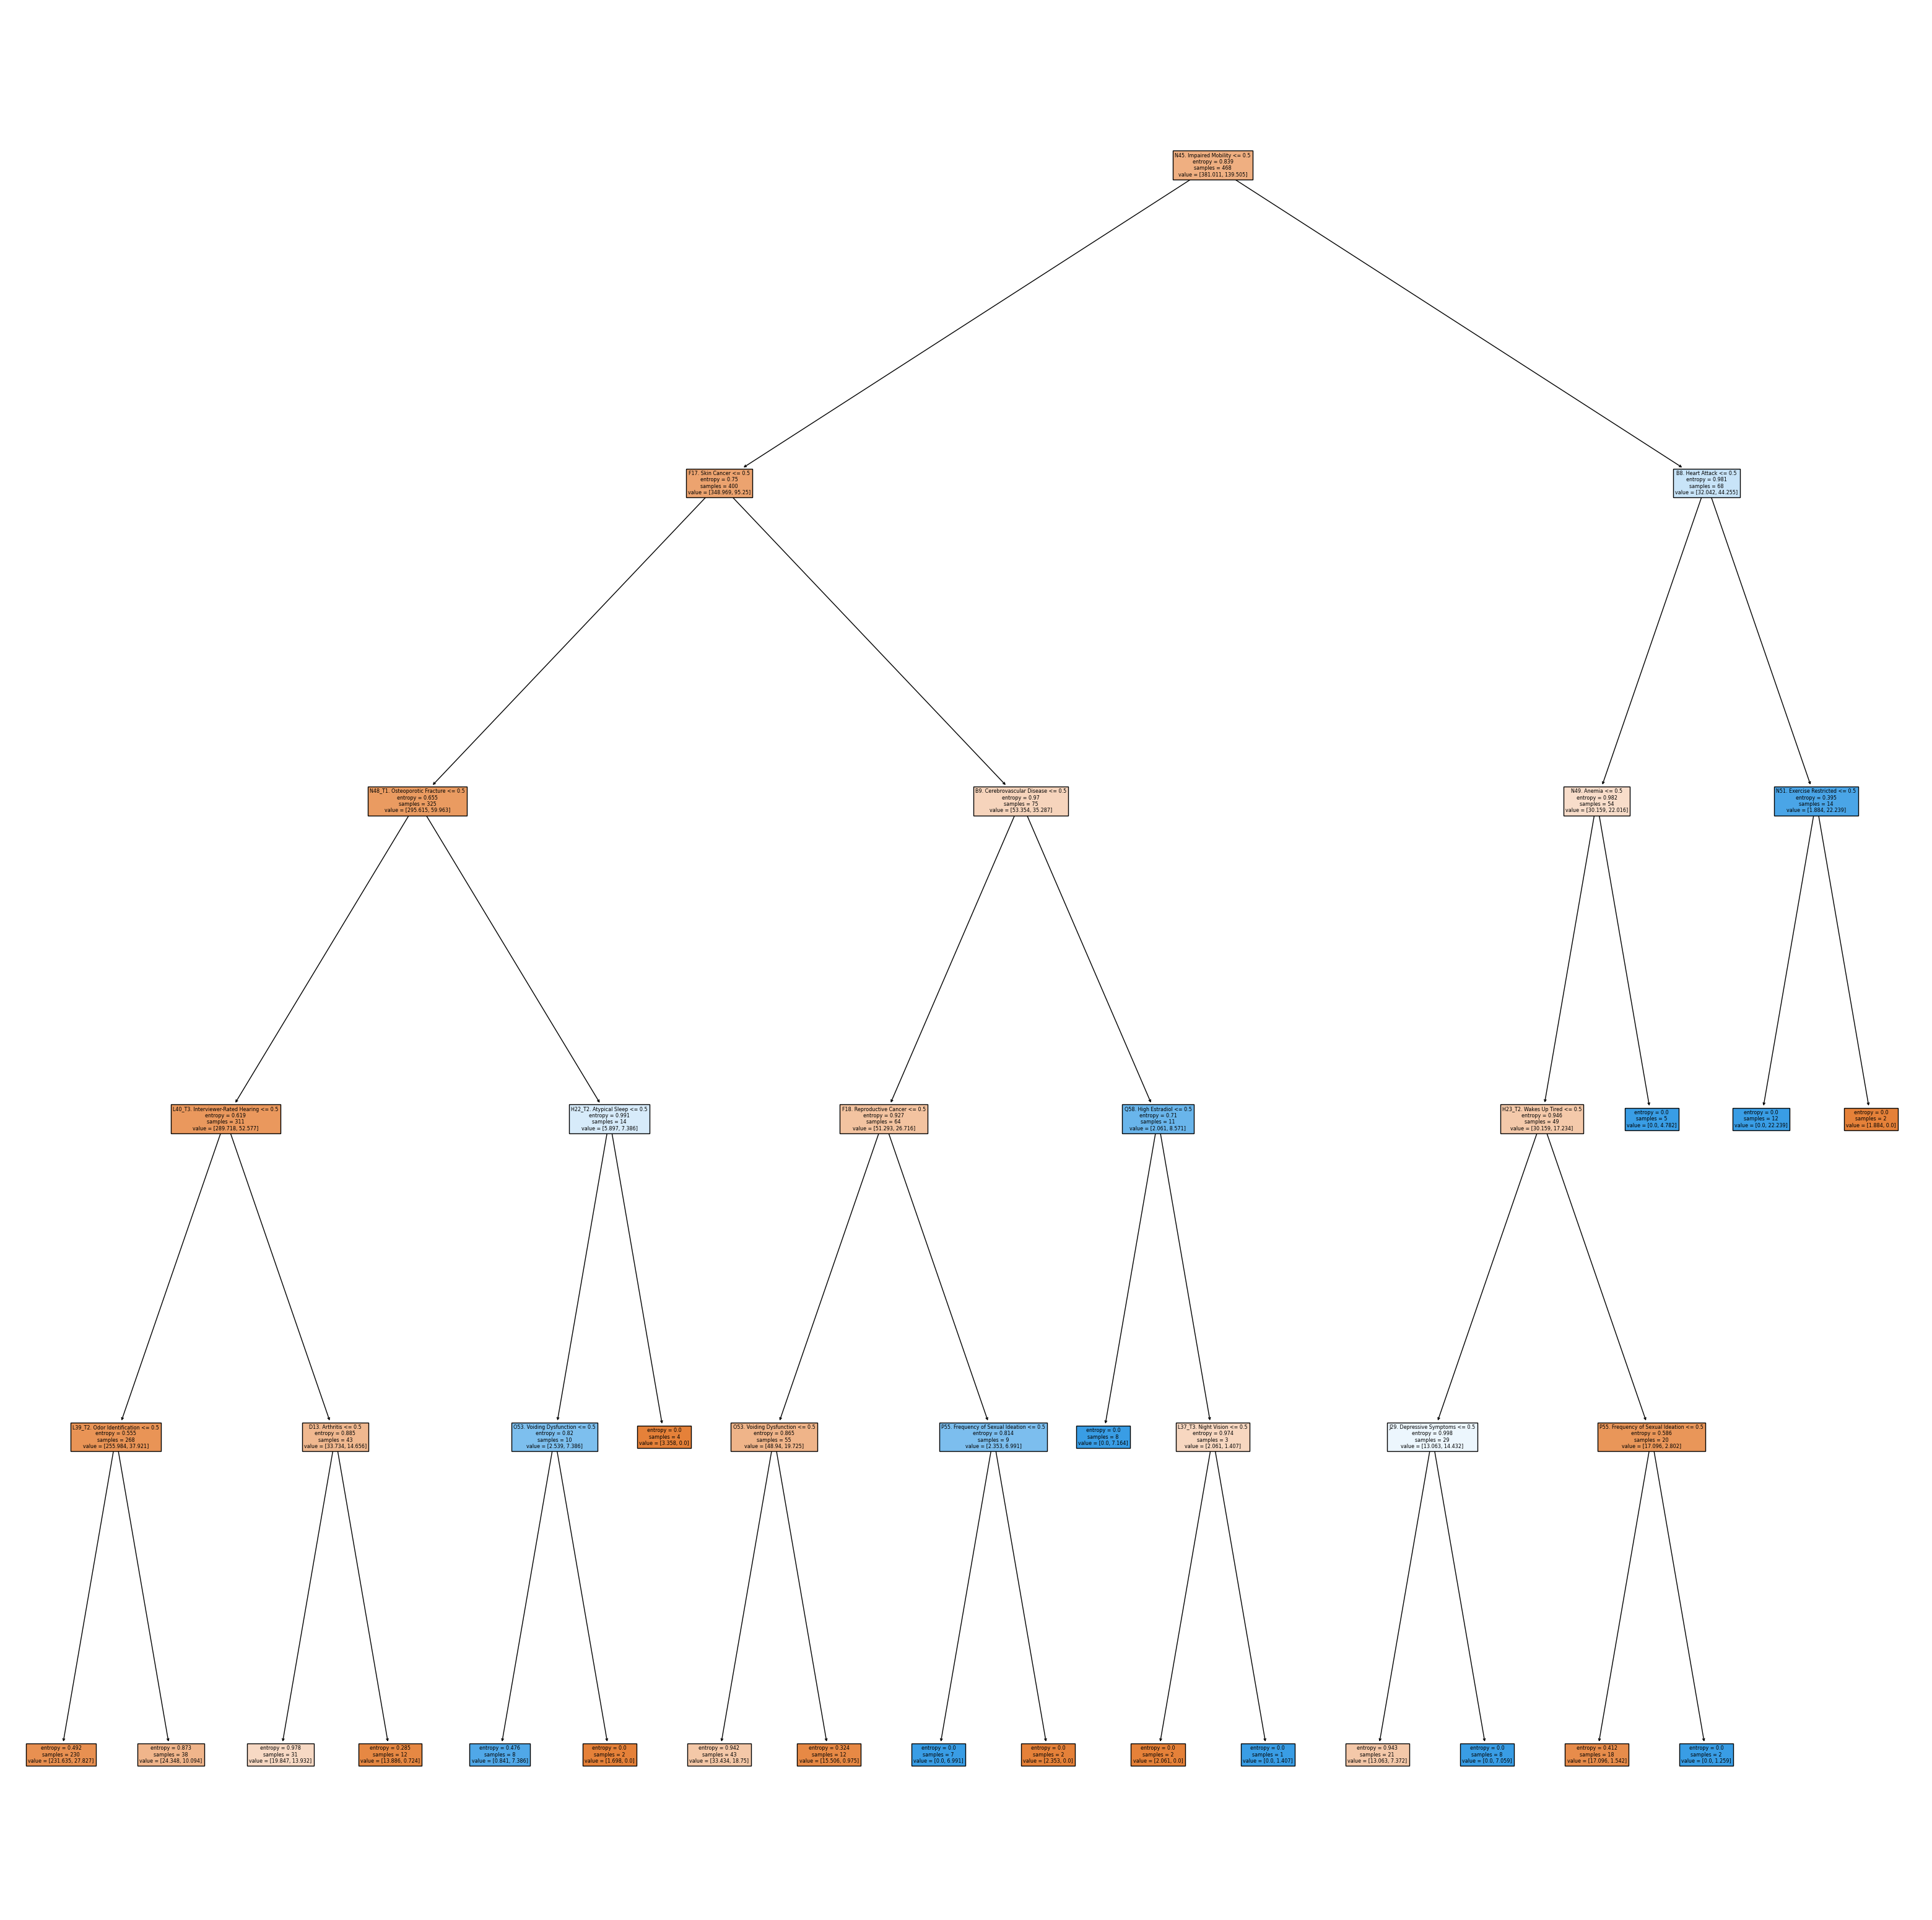

Performence on train set 0.8423520184145598
Performence on test set 0.7927104434096562
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88 102.37358063459396
         1.0       0.73      0.17      0.28 31.098485335707664

    accuracy                           0.79 133.47206597030163
   macro avg       0.76      0.58      0.58 133.47206597030163
weighted avg       0.78      0.79      0.74 133.47206597030163



In [88]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 4]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [89]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
0      0.0           0.0          0.0   
4      1.0           0.0          0.0   
13     0.0           0.0          1.0   
22     1.0           0.0          0.0   
28     1.0           1.0          0.0   
32     1.0           0.0          0.0   
38     1.0           0.0          0.0   
46     1.0           0.0          0.0   
48     1.0           0.0          0.0   
50     1.0           0.0          0.0   
53     1.0           0.0          0.0   
59     1.0           1.0          0.0   
64     1.0           0.0          0.0   
66     1.0           0.0          0.0   
67     1.0           0.0          0.0   
68     1.0           0.0          0.0   
71     1.0           0.0          0.0   
74     1.0           0.0          1.0   
78     1.0           0.0          0.0   
79     1.0           1.0          0.0   
83     1.0           0.0          0.0   
88     1.0           0.0          0.0   
92     1.0           0.0          0.0   
93     1.0           0.0          0.0   
95     1.0           1.0          0.0   
101    1.0           0.0          0.0   
102    1.0           0.0          0.0   
107    1.0           1.0          1.0   
112    1.0           1.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
0                                        0.0               0.0   
4                                        0.0               1.0   
13                                       0.0               1.0   
22                                       0.0               0.0   
28                                       1.0               1.0   
32                                       0.0               0.0   
38                                       0.0               1.0   
46                                       0.0               1.0   
48                                       0.0               0.0   
50                                       0.0               1.0   
53                                       0.0               1.0   
59                                       0.0               1.0   
64                                       0.0               1.0   
66                                       0.0               1.0   
67                                       0.0               0.0   
68                                       0.0               1.0   
71                                       0.0               1.0   
74                                       0.0               0.0   
78                                       0.0               0.0   
79                                       0.0               1.0   
83                                       0.0               0.0   
88                                       0.0               1.0   
92                                       0.0               1.0   
93                                       0.0               0.0   
95                                       0.0               1.0   
101                                      0.0               1.0   
102                                      0.0               0.0   
107                                      0.0               0.0   
112                                      0.0               1.0   

     B8. Heart Attack  B9. Cerebrovascular Disease  B10. Heart Failure  \
0                 1.0                          1.0                 0.0   
4                 0.0                          1.0                 0.0   
13                0.0                          1.0                 0.0   
22                0.0                          0.0                 0.0   
28                0.0                          0.0                 1.0   
32                0.0                          0.0                 0.0   
38                0.0                          0.0                 0.0   
46                0.0                          0.0                 1.0   
48                0.0                          0.0                 0.0   
50                0.0                          0.0   

## Race

1536


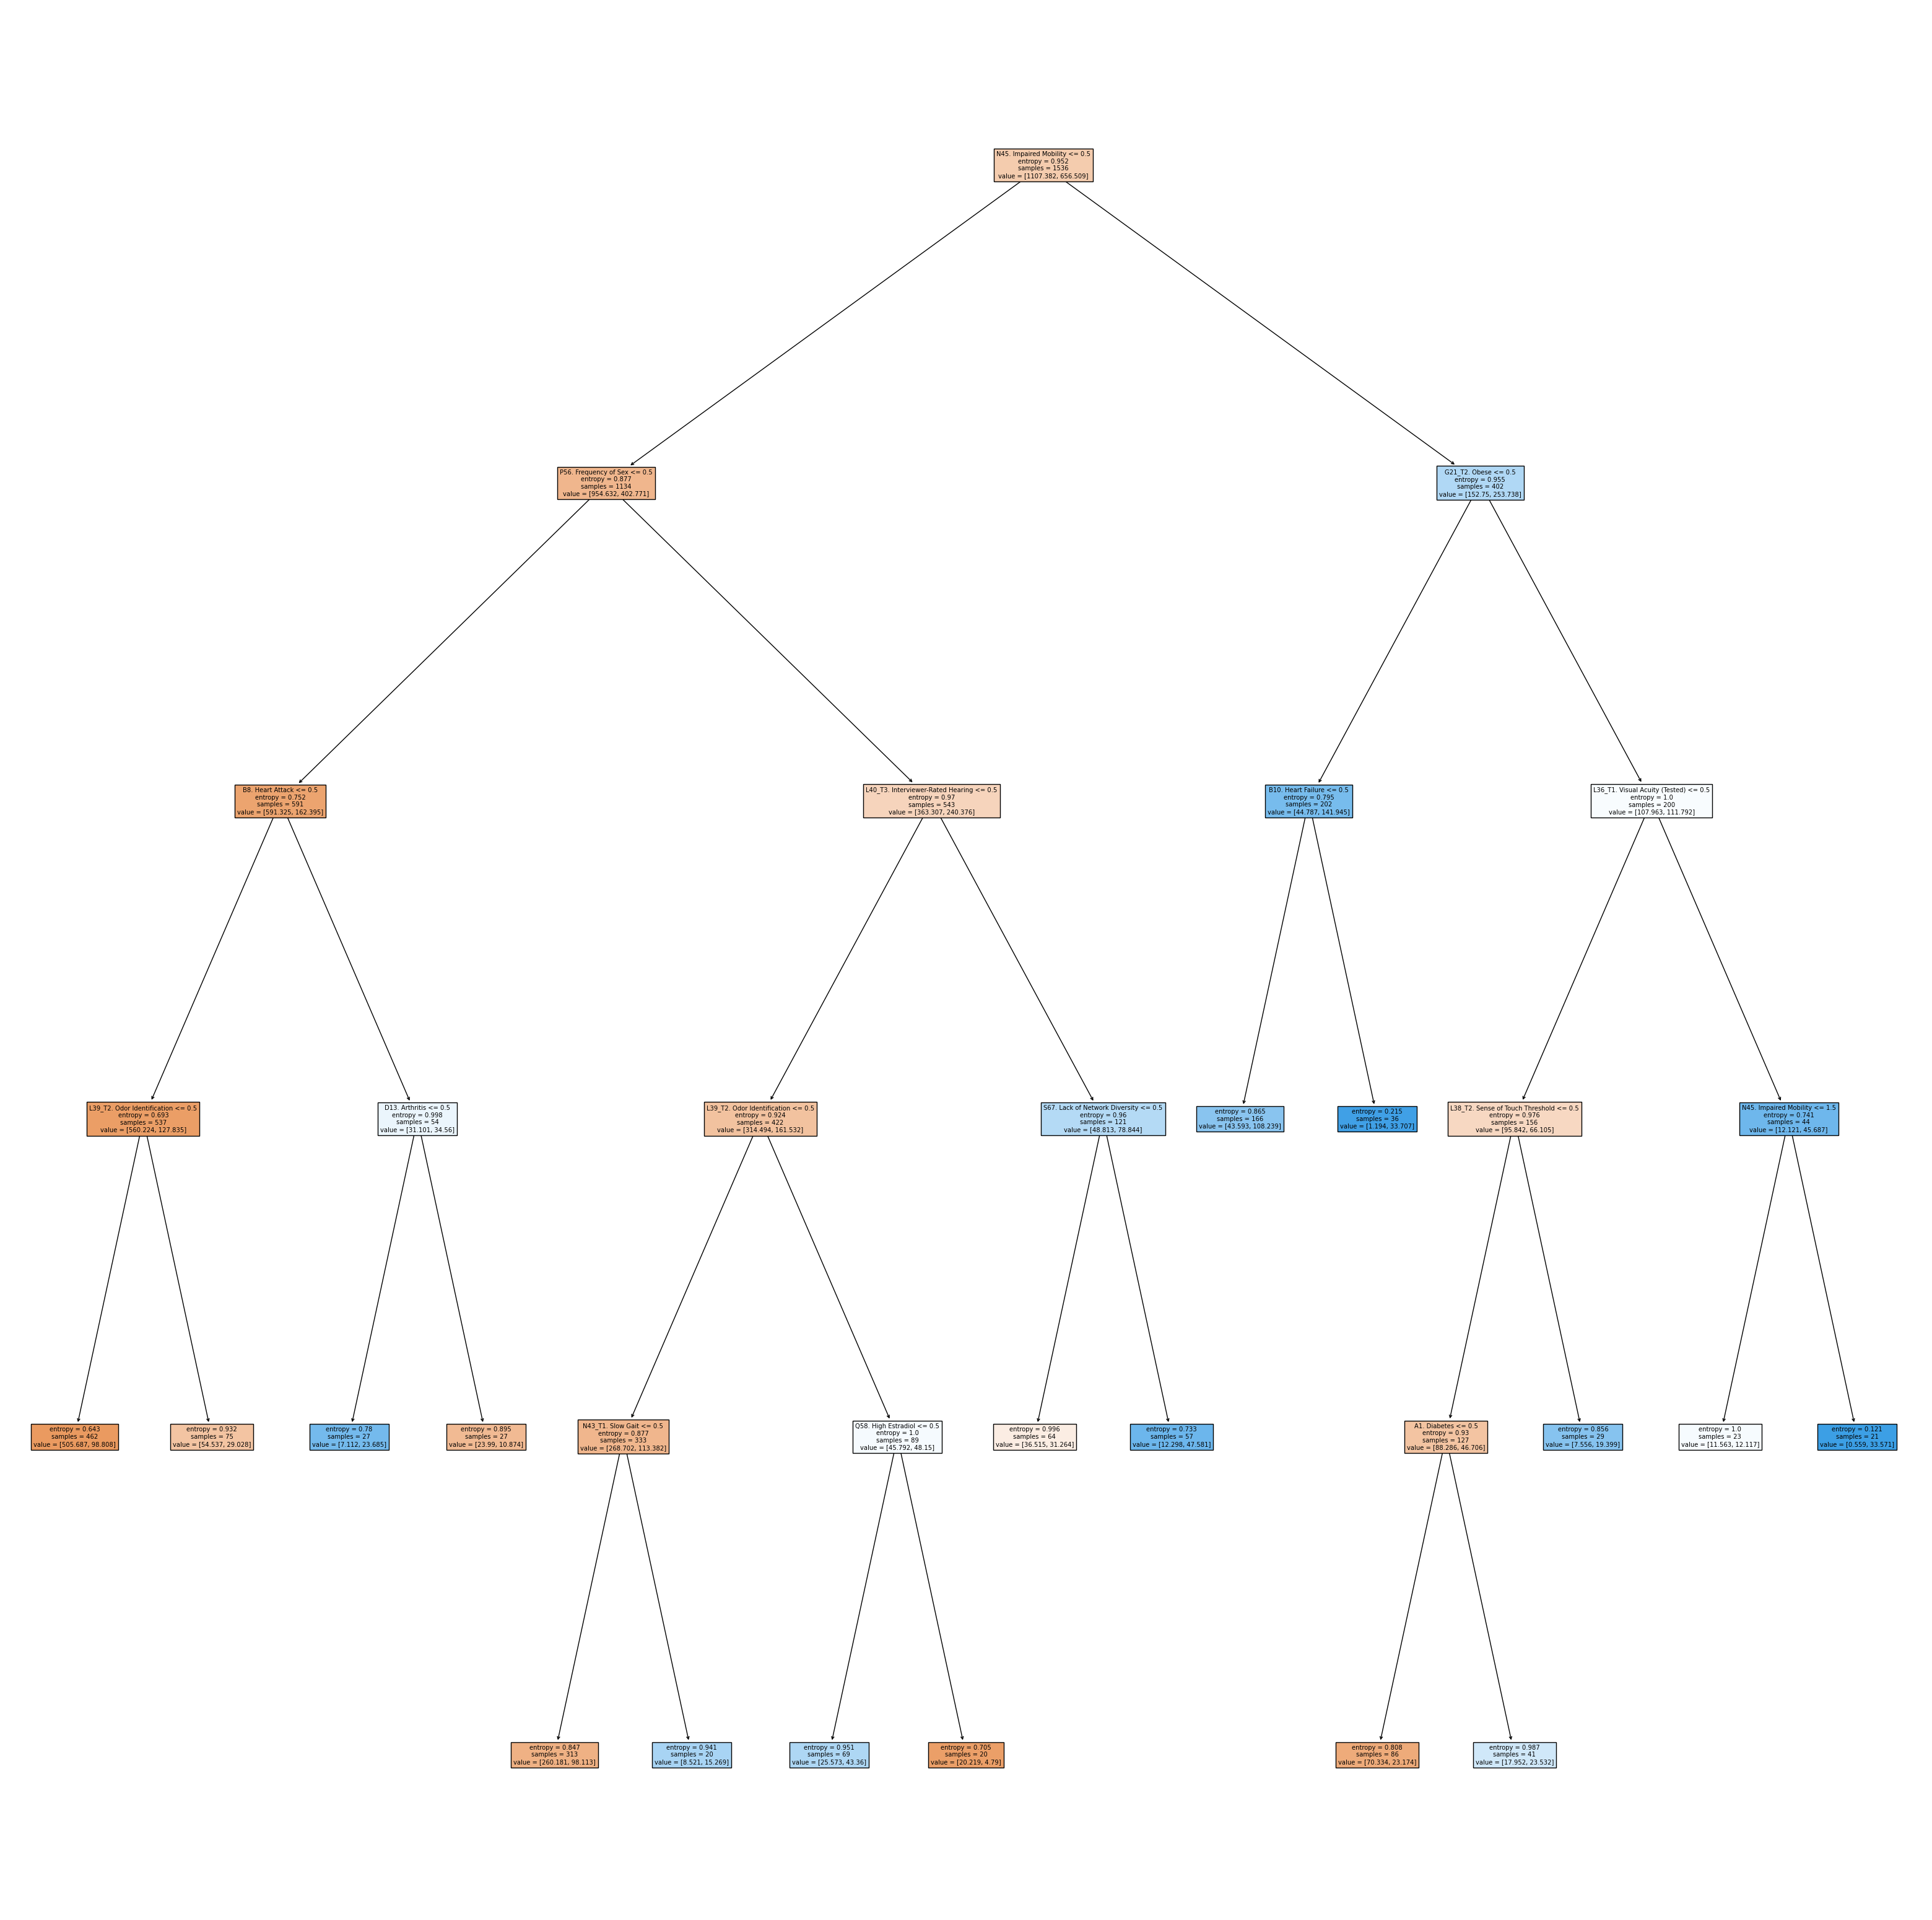

Performence on train set 0.7551039633428515
Performence on test set 0.7210058902253198
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79 267.497945278883
         1.0       0.68      0.51      0.58 163.08729159832

    accuracy                           0.72 430.585236877203
   macro avg       0.71      0.68      0.69 430.585236877203
weighted avg       0.71      0.72      0.71 430.585236877203



In [90]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [91]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
0      0.0           0.0          0.0   
4      1.0           0.0          0.0   
8      1.0           0.0          0.0   
14     0.0           1.0          0.0   
20     1.0           0.0          1.0   
..     ...           ...          ...   
360    1.0           0.0          0.0   
366    0.0           1.0          0.0   
367    0.0           0.0          0.0   
372    1.0           1.0          1.0   
375    1.0           0.0          1.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
0                                        0.0               1.0   
4                                        1.0               1.0   
8                                        1.0               0.0   
14                                       0.0               1.0   
20                                       0.0               1.0   
..                                       ...               ...   
360                                      0.0               0.0   
366                                      1.0               1.0   
367                                      0.0               0.0   
372                                      0.0               1.0   
375                                      0.0               1.0   

     B8. Heart Attack  B9. Cerebrovascular Disease  B10. Heart Failure  \
0                 0.0                          0.0                 0.0   
4                 0.0                          0.0                 0.0   
8                 0.0                          0.0                 0.0   
14                0.0                          0.0                 0.0   
20                0.0                          0.0                 0.0   
..                ...                          ...                 ...   
360               0.0                          0.0                 0.0   
366               0.0                          1.0                 1.0   
367               0.0                          0.0                 0.0   
372               0.0                          0.0                 0.0   
375               0.0                          0.0                 0.0   

     BT_T2. Systolic Blood Pressure  B6_T2. Diastolic Blood Pressure  ...  \
0                               0.0                              0.0  ...   
4                               1.0                              0.0  ...   
8                               1.0                              1.0  ...   
14                              0.0                              0.0  ...   
20                              0.0                              1.0  ...   
..                              ...                              ...  ...   
360                             0.0                              0.0  ...   
366                             1.0                              1.0  ...   
367                             0.0                              0.0  ...   
372                             1.0                              0.0  ...   
375                             0.0                              1.0  ...   

     Q57. Low Testosterone  Q58. High Estradiol  Q59. Low/High Progesterone  \
0                      0.0                  0.0                         0.0   
4                      0.0                  1.0                         0.0   
8                      0.0                  0.0                         0.0   
14                     0.0                  1.0                         0.0   
20                     0.0                  0.0                         0.0   
..                     ...                  ...                         ...   
360                    1.0                  0.0                         0.0   
366                    0.0                  1.0                         0.0   
367                    0.0                  0.0                         0.0   
372                    0.0                  0.0                         0.0   
375                    0.0          

361


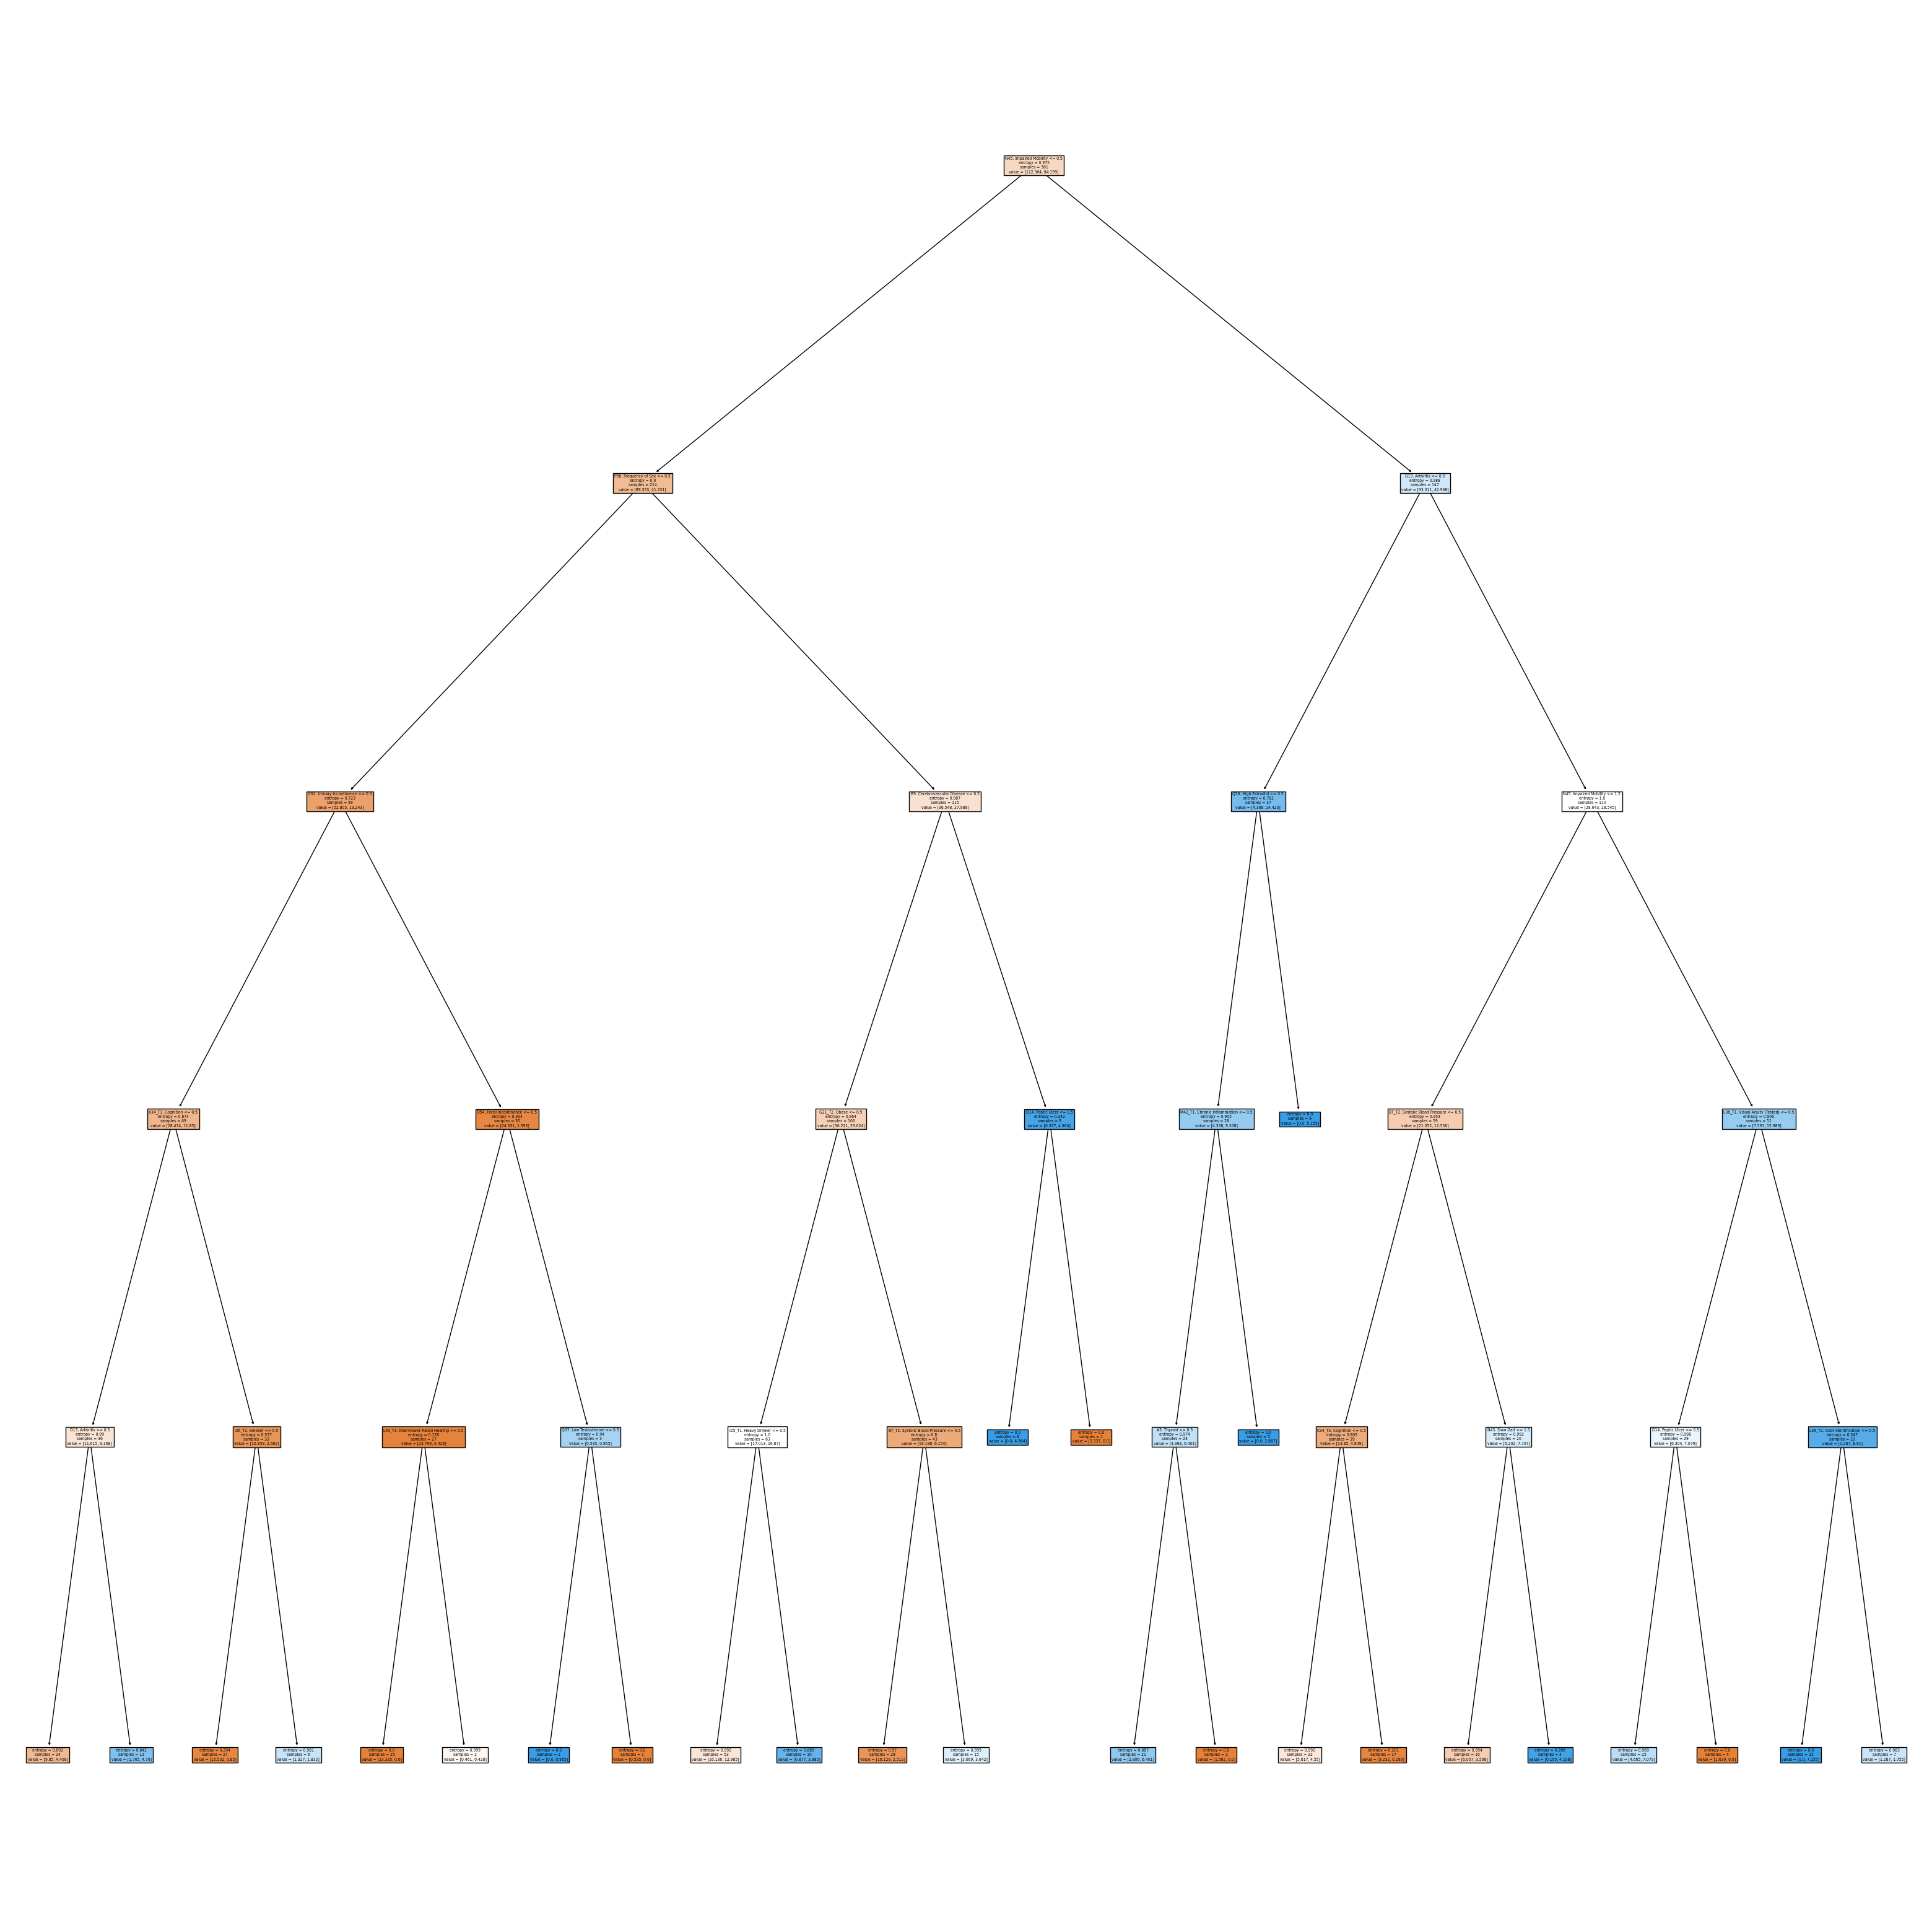

Performence on train set 0.7791417987336519
Performence on test set 0.6207591509648759
              precision    recall  f1-score   support

         0.0       0.73      0.65      0.69 35.31773714721203
         1.0       0.47      0.56      0.51 19.083082512021065

    accuracy                           0.62 54.40081965923309
   macro avg       0.60      0.61      0.60 54.40081965923309
weighted avg       0.64      0.62      0.63 54.40081965923309



In [92]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [93]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
1     0.0           0.0          0.0                                      0.0   
2     0.0           0.0          0.0                                      0.0   
3     1.0           0.0          0.0                                      0.0   
7     1.0           1.0          0.0                                      1.0   
8     1.0           0.0          0.0                                      0.0   
9     0.0           1.0          0.0                                      0.0   
11    0.0           1.0          0.0                                      0.0   
12    1.0           1.0          0.0                                      0.0   
14    0.0           0.0          0.0                                      0.0   
15    1.0           1.0          0.0                                      0.0   
19    0.0           0.0          0.0                                      0.0   
21    1.0           0.0          0.0                                      0.0   
25    0.0           0.0          0.0                                      0.0   
29    1.0           1.0          0.0                                      1.0   
30    1.0           0.0          0.0                                      1.0   
37    1.0           0.0          0.0                                      0.0   
38    0.0           0.0          0.0                                      0.0   
39    0.0           0.0          1.0                                      0.0   
44    1.0           1.0          0.0                                      0.0   
46    0.0           0.0          1.0                                      0.0   
48    1.0           0.0          0.0                                      0.0   
51    1.0           0.0          0.0                                      0.0   
53    1.0           0.0          0.0                                      0.0   
58    1.0           0.0          0.0                                      0.0   
60    1.0           0.0          0.0                                      0.0   
62    1.0           1.0          0.0                                      0.0   
63    0.0           1.0          0.0                                      1.0   
64    1.0           0.0          0.0                                      1.0   
65    0.0           0.0          0.0                                      0.0   
67    1.0           0.0          0.0                                      0.0   
70    0.0           0.0          1.0                                      1.0   
71    0.0           0.0          0.0                                      0.0   
73    0.0           1.0          0.0                                      0.0   
80    0.0           1.0          0.0                                      1.0   
81    1.0           1.0          0.0                                      0.0   
84    0.0           0.0          0.0                                      0.0   
89    0.0           0.0          0.0                                      0.0   

    B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
1                1.0               0.0                          0.0   
2                1.0               0.0                          0.0   
3                0.0               0.0                          0.0   
7                1.0               0.0                          0.0   
8                1.0               0.0                          0.0   
9                1.0               0.0                          0.0   
11               0.0               0.0                          0.0   
12               1.0               0.0                          0.0   
14               0.0               0.0                          0.0   
15               1.0               0.0                          0.0   
19               1.0               0.0                          0.0   
21               1.0               0.0                          0.0   
25

204


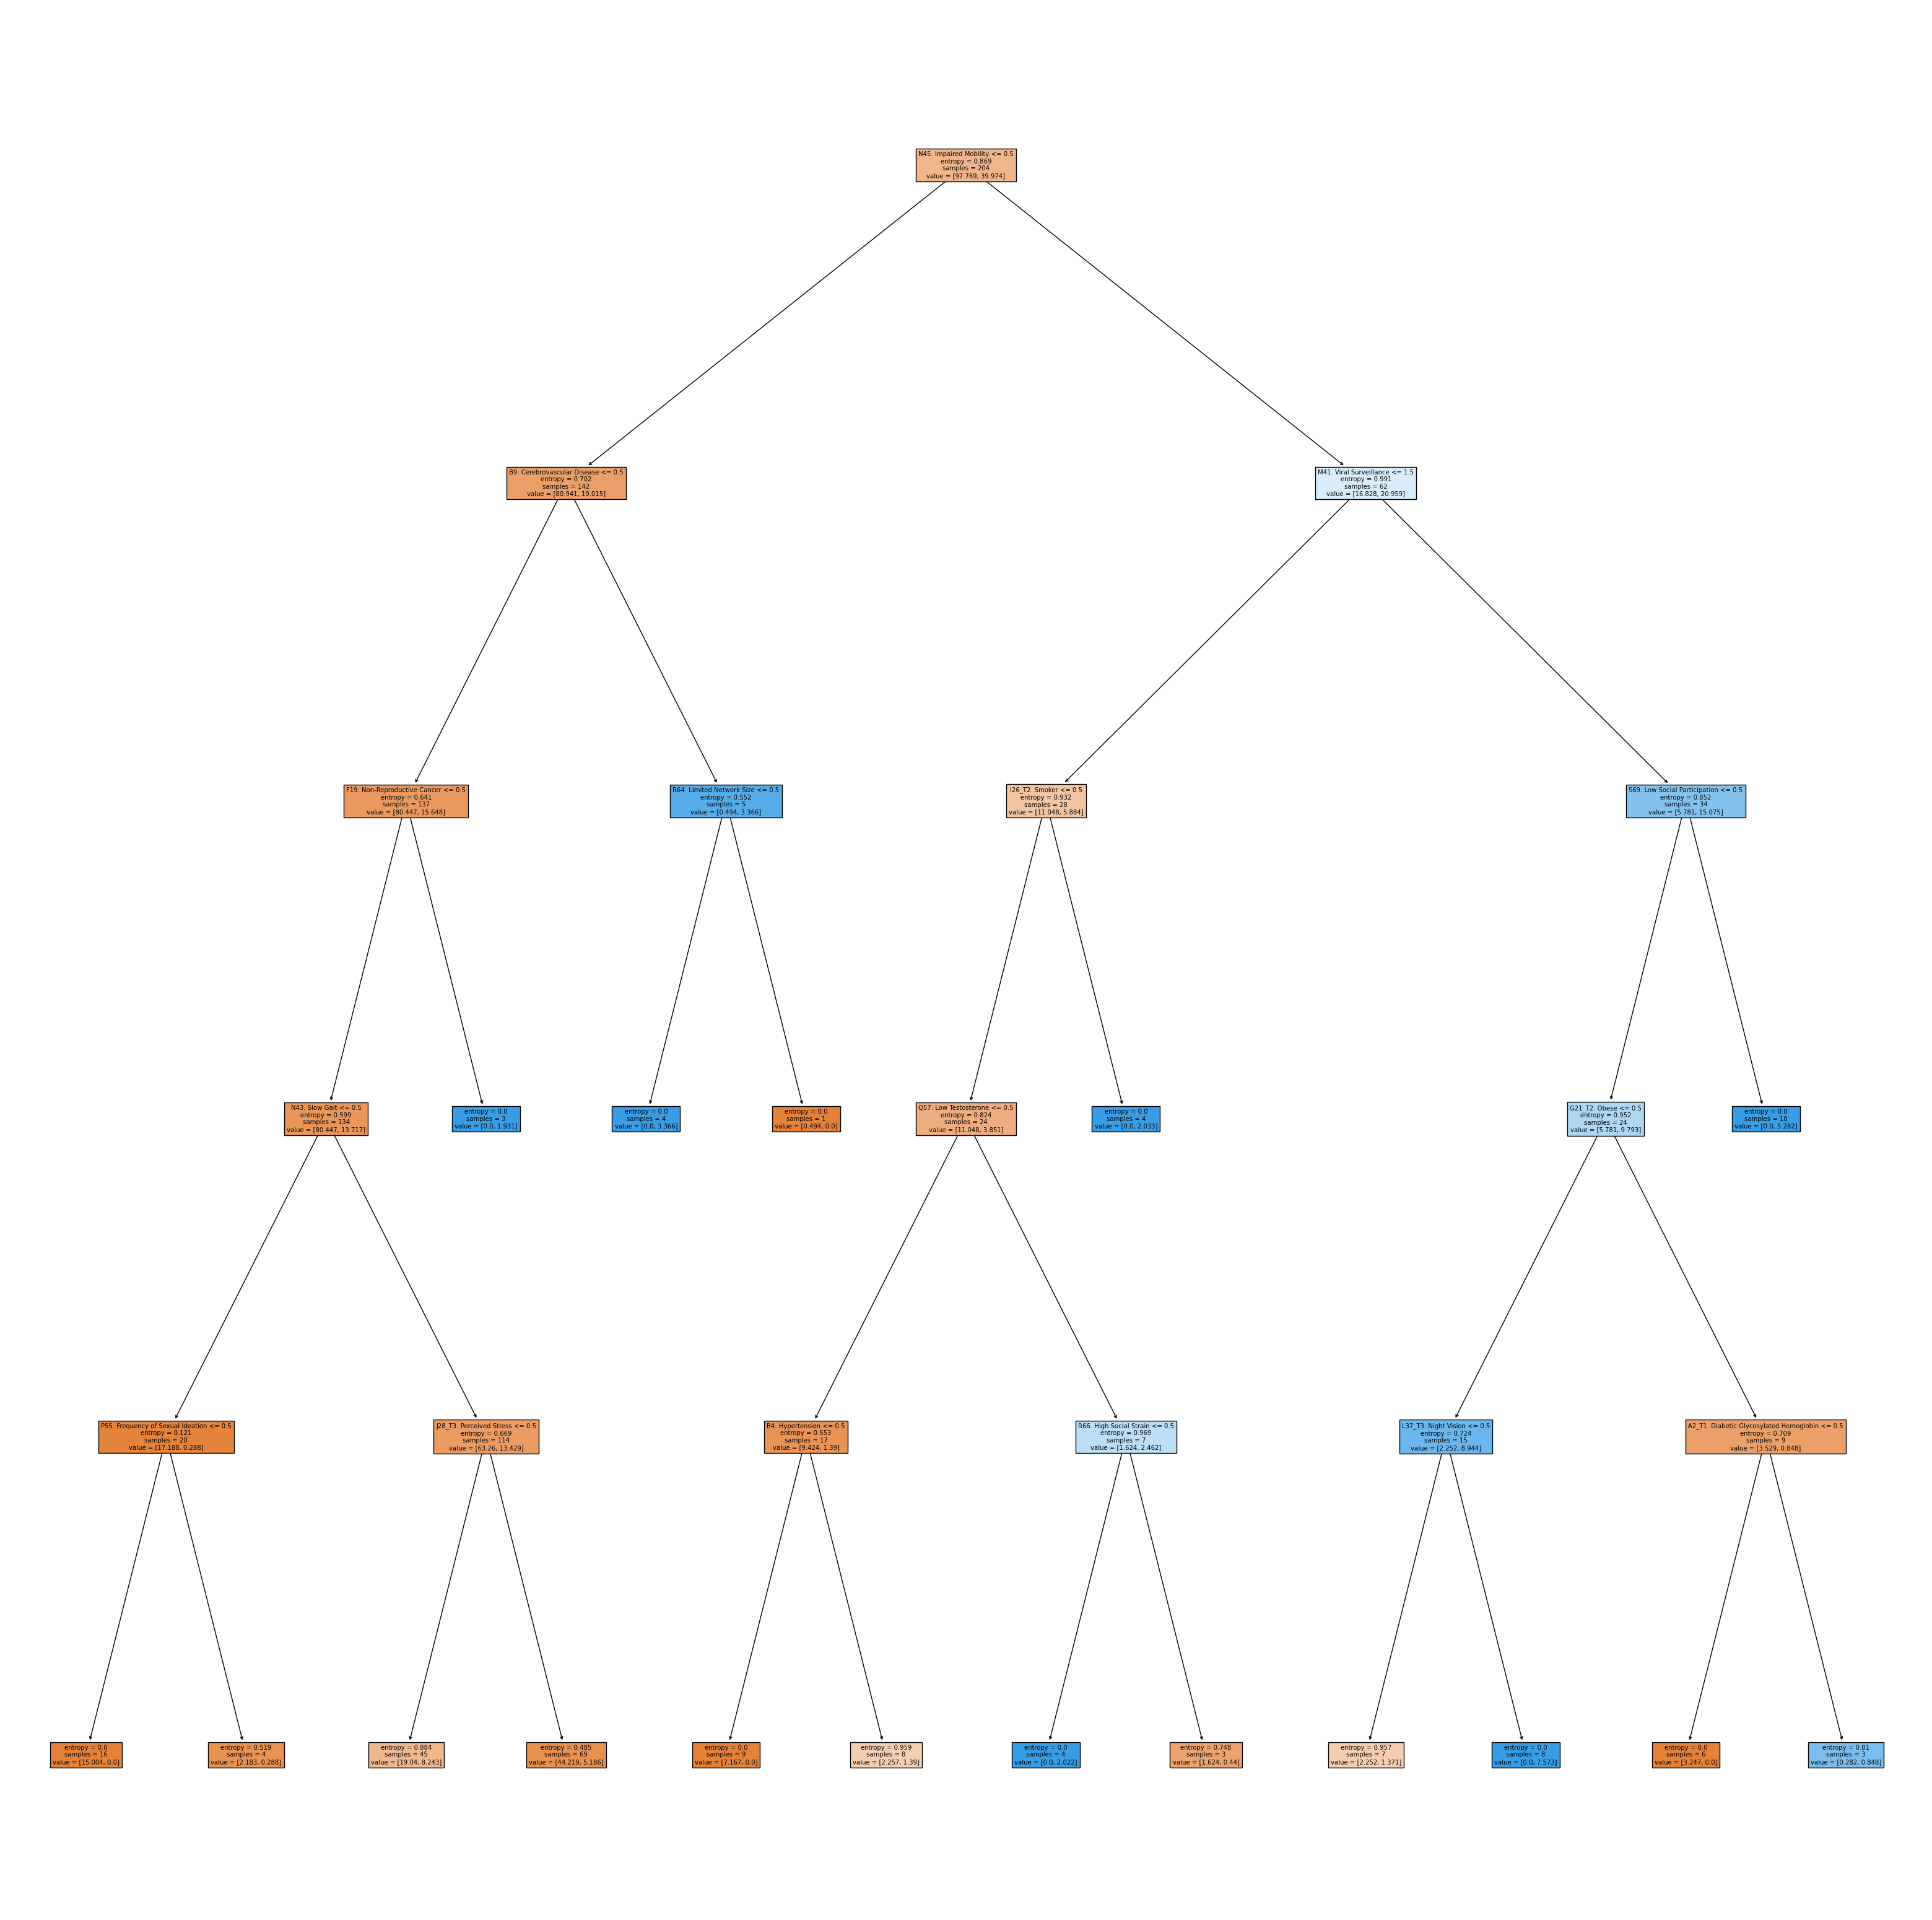

Performence on train set 0.8751355852915786
Performence on test set 0.7383745486150032
              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83 21.858988344669342
         1.0       0.69      0.30      0.42 10.002640679478645

    accuracy                           0.74 31.861629024147987
   macro avg       0.72      0.62      0.63 31.861629024147987
weighted avg       0.73      0.74      0.70 31.861629024147987



In [94]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [95]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
0     1.0           0.0          0.0                                      0.0   
1     1.0           0.0          0.0                                      0.0   
6     0.0           0.0          0.0                                      0.0   
10    0.0           0.0          0.0                                      0.0   
14    1.0           1.0          0.0                                      1.0   
15    1.0           0.0          0.0                                      0.0   
19    1.0           0.0          0.0                                      0.0   
21    1.0           0.0          0.0                                      0.0   
28    1.0           1.0          0.0                                      1.0   
31    1.0           1.0          1.0                                      1.0   
33    1.0           1.0          0.0                                      0.0   
34    0.0           0.0          0.0                                      0.0   
37    1.0           1.0          0.0                                      1.0   
38    1.0           0.0          0.0                                      0.0   
39    1.0           0.0          0.0                                      0.0   
41    1.0           1.0          0.0                                      0.0   

    B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
0                0.0               0.0                          0.0   
1                1.0               0.0                          0.0   
6                1.0               0.0                          0.0   
10               0.0               1.0                          0.0   
14               0.0               0.0                          0.0   
15               0.0               0.0                          0.0   
19               0.0               0.0                          0.0   
21               0.0               0.0                          0.0   
28               1.0               0.0                          0.0   
31               1.0               0.0                          0.0   
33               1.0               1.0                          0.0   
34               1.0               0.0                          0.0   
37               0.0               0.0                          0.0   
38               0.0               0.0                          0.0   
39               1.0               0.0                          0.0   
41               1.0               0.0                          0.0   

    B10. Heart Failure  BT_T2. Systolic Blood Pressure  \
0                  0.0                             0.0   
1                  1.0                             0.0   
6                  0.0                             1.0   
10                 0.0                             1.0   
14                 1.0                             0.0   
15                 0.0                             1.0   
19                 0.0                             0.0   
21                 0.0                             0.0   
28                 1.0                             0.0   
31                 0.0                             0.0   
33                 1.0                             0.0   
34                 0.0                             0.0   
37                 0.0                             1.0   
38                 0.0                             0.0   
39                 0.0                             0.0   
41                 0.0                             0.0   

    B6_T2. Diastolic Blood Pressure  ...  Q57. Low Testosterone  \
0                               0.0  ...                    0.0   
1                               0.0  ...                    0.0   
6                               0.0  ...                    0.0   
10                              0.0  ...                    1.0   
14                              0.0  ...                    1.0   
15                           

44


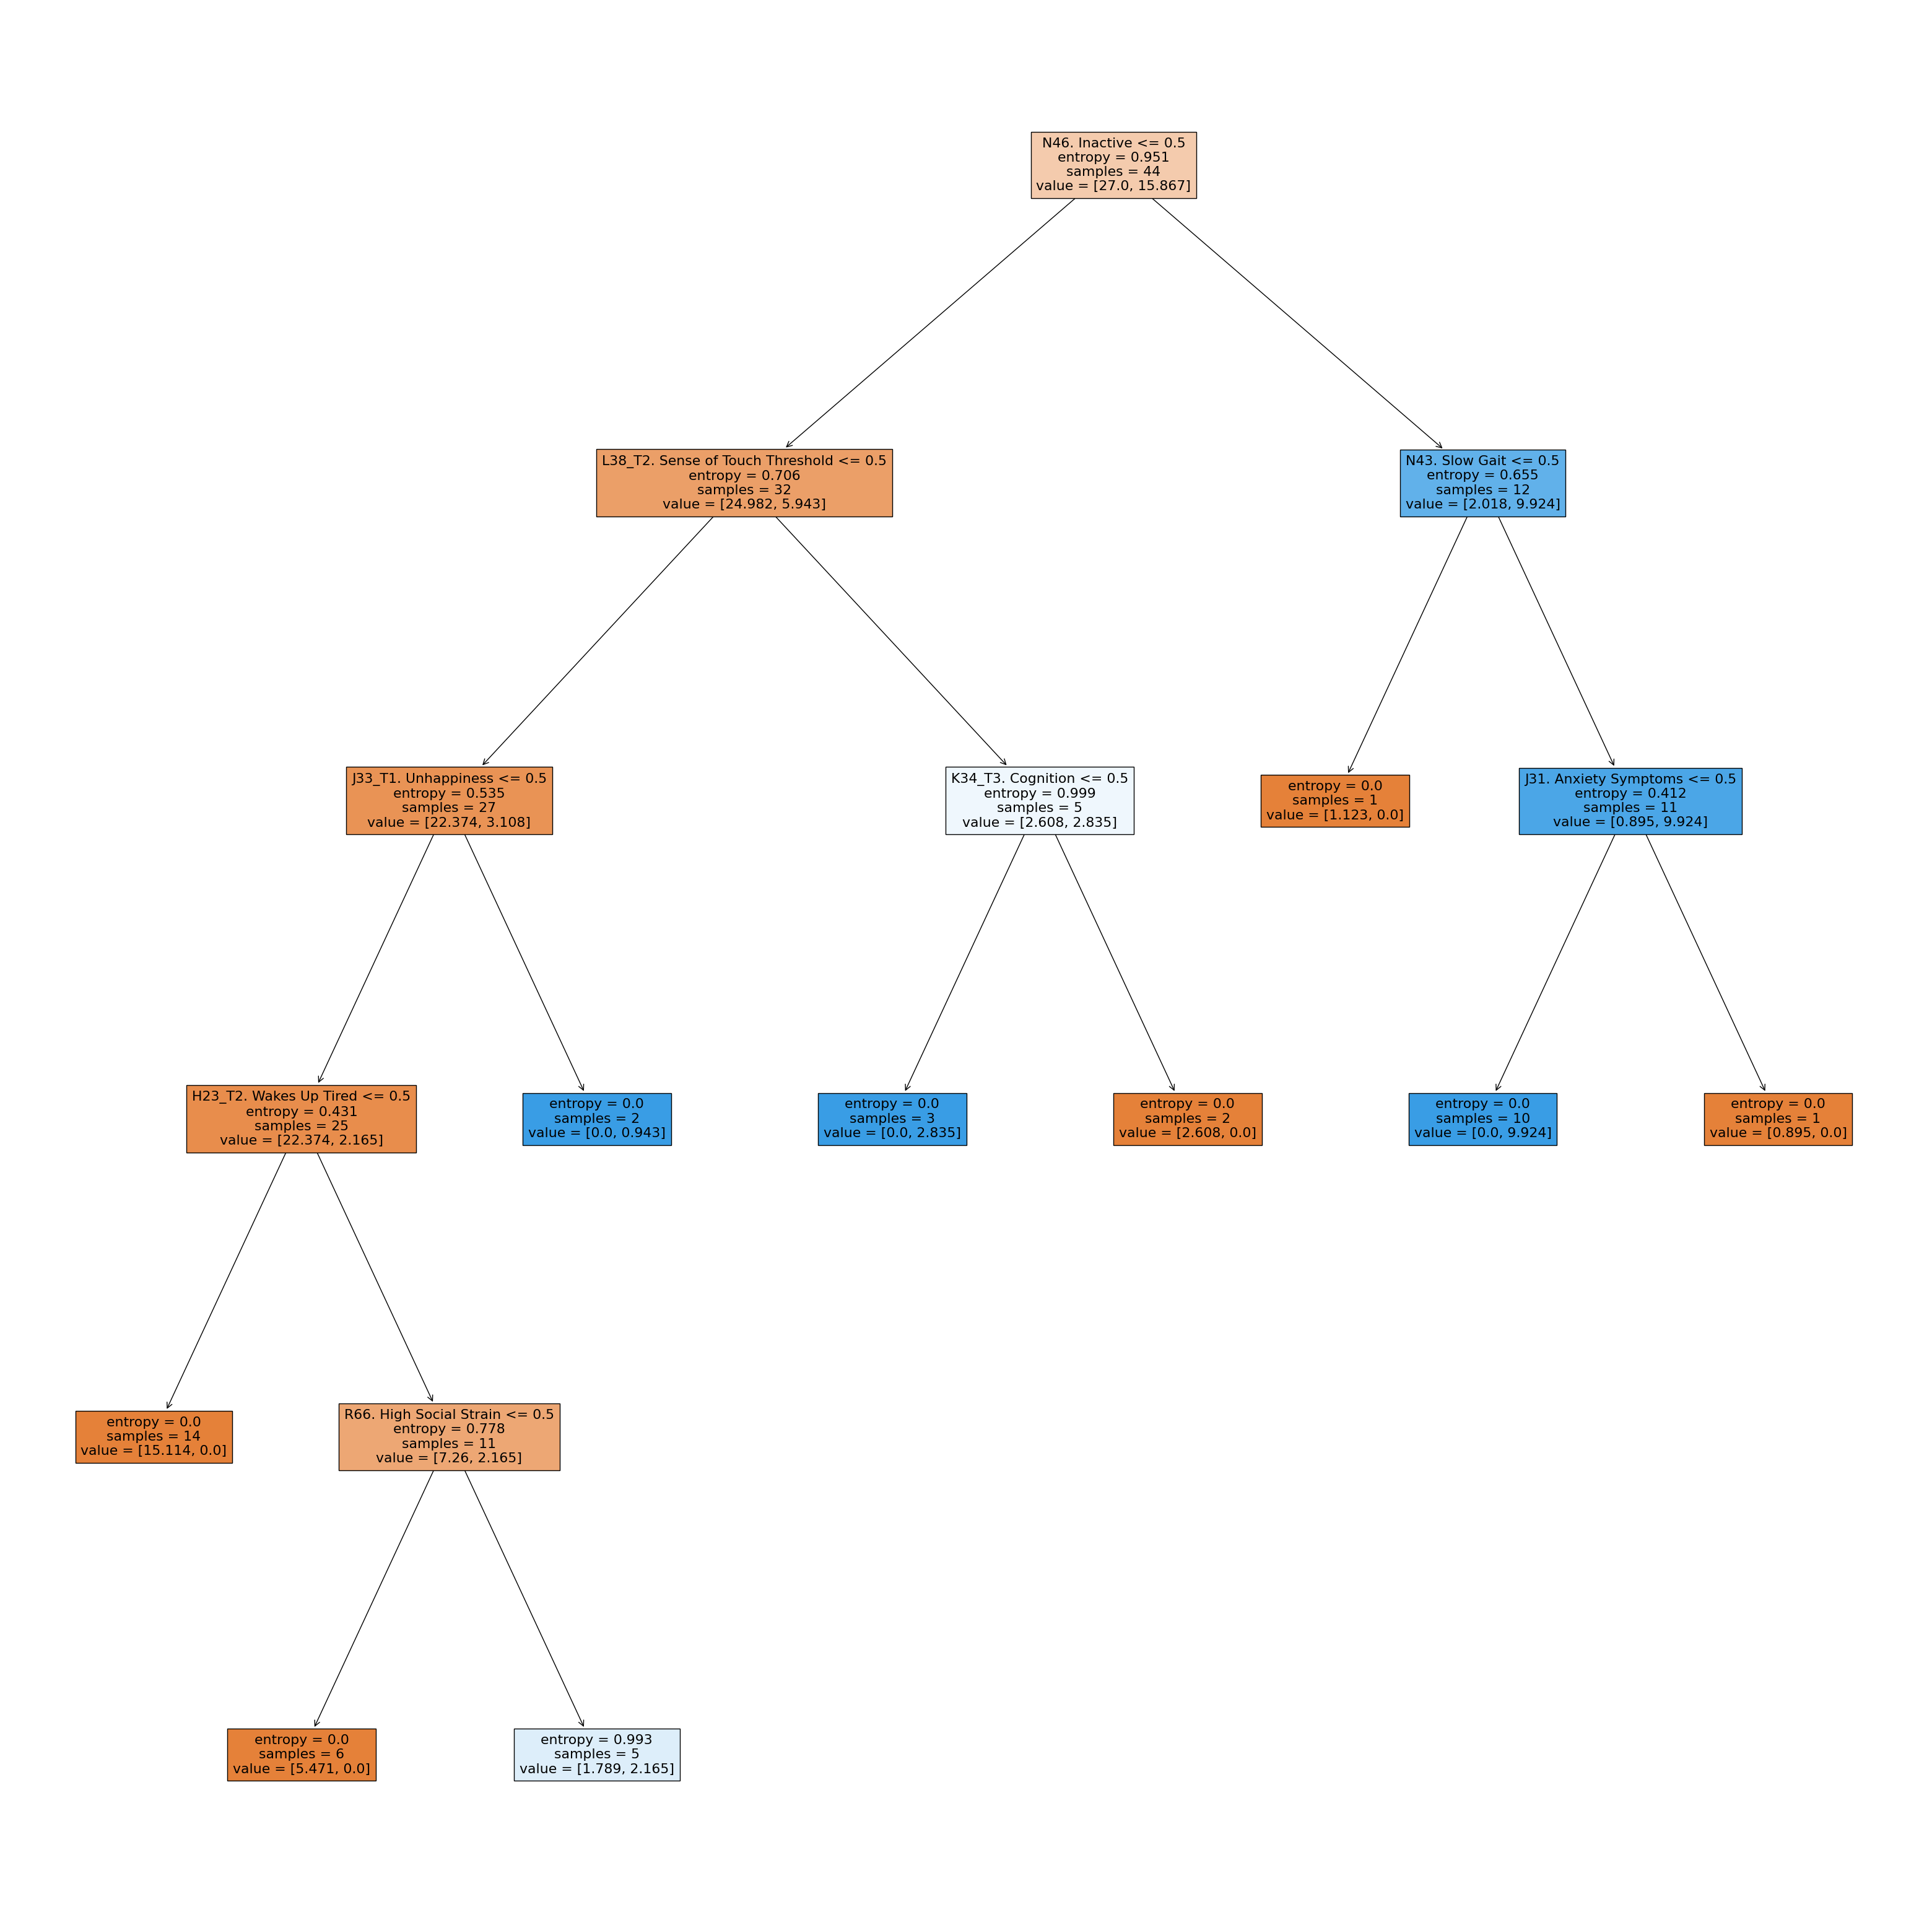

Performence on train set 0.9582625726625033
Performence on test set 0.4635061099058653
              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55 8.539509743452072
         1.0       0.35      0.33      0.34 6.017254054546356

    accuracy                           0.46 14.556763797998428
   macro avg       0.44      0.44      0.44 14.556763797998428
weighted avg       0.46      0.46      0.46 14.556763797998428



In [96]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 4]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

In [97]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='Weight', inplace=False))[:, 1], columns=["Label"])
X_wrong_dt = X_test.drop(columns='Weight', inplace=False).reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
3    1.0           0.0          0.0                                      0.0   
6    1.0           1.0          0.0                                      1.0   
8    1.0           0.0          0.0                                      0.0   
9    0.0           0.0          0.0                                      0.0   

   B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
3               1.0               0.0                          1.0   
6               1.0               1.0                          0.0   
8               0.0               0.0                          0.0   
9               1.0               0.0                          1.0   

   B10. Heart Failure  BT_T2. Systolic Blood Pressure  \
3                 0.0                             1.0   
6                 0.0                             0.0   
8                 0.0                             1.0   
9                 0.0                             0.0   

   B6_T2. Diastolic Blood Pressure  ...  Q57. Low Testosterone  \
3                              0.0  ...                    0.0   
6                              0.0  ...                    0.0   
8                              0.0  ...                    0.0   
9                              0.0  ...                    0.0   

   Q58. High Estradiol  Q59. Low/High Progesterone  Q60. Low DHEA  \
3                  1.0                         1.0            0.0   
6                  1.0                         0.0            0.0   
8                  0.0                         1.0            0.0   
9                  0.0                         0.0            0.0   

   R63. Unmarried/Unpartnered  R64. Limited Network Size  \
3                         1.0                        0.0   
6                         0.0                        0.0   
8                         0.0                        0.0   
9                         1.0                        0.0   

   R65. Low Social Support  R66. High Social Strain  \
3                      0.0                      0.0   
6                      0.0                      0.0   
8                      0.0                      1.0   
9                      0.0                      0.0   

   S67. Lack of Network Diversity  S69. Low Social Participation  
3                             0.0                            0.0  
6                             1.0                            0.0  
8                             0.0                            0.0  
9                             1.0                            0.0  

[4 rows x 70 columns]